In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
np.random.seed(42)
from joblib import Parallel, delayed
import multiprocessing
from itertools import chain
# Matplotlib command for Jupyter notebooks only
%matplotlib inline



In [10]:
import sys

sys.path.append("/home/mklein/sc_imputation_denoising")
import sc_imputation_denoising as scid

save_to = os.path.join(scid.WD, "thesis_analysis/02_03_dropout_simulation", "data")
if not os.path.exists(save_to):
    os.makedirs(save_to)
    
from sc_imputation_denoising.imputation.constants import const

from sc_imputation_denoising.imputation.simulation import (
    get_dropout_rate,
    calculate_dropout_rate_array,
    simulate_dropouts_mcar_array,
    simulate_dropouts_mnar_array,
)

from sc_imputation_denoising.evaluation.evaluation_workflow import (
    evaluation_workflow
)

In [3]:
# def get_dropout_rate(adata, layer=None, v=True, groupby=None):
    
#     if layer is None:
#         rate = calculate_dropout_rate_array(adata.X, v=v)
#     else:
#         rate = calculate_dropout_rate_array(adata.layers[layer], v=v)
    
#     if groupby is not None:
#         if not isinstance(groupby, list):
#             groupby = [groupby]
#         rate = sc.get.obs_df(
#             adata, 
#             layer=layer,
#             keys=list(adata.var_names) + groupby
#         ).reset_index().melt(
#                 id_vars=["cell_id"] + groupby,
#                 value_name='dropout_ratio'
#         )[['dropout_ratio'] + groupby].groupby(groupby).agg(
#             lambda x: x.eq(0).sum() / x.count()
#         ).dropna()
#     return rate

# def calculate_dropout_rate_array(array, v=True):

#     rate = 1 - (np.count_nonzero(array) / array.size)
#     if v: print("Global dropout rate: %1.2f Percent"%(100*rate))
#     return rate


In [4]:
# def simulate_dropouts_mcar_adata(adata, rate):
#     adata_dropped = adata.copy()
#     adata_dropped.X = simulate_dropouts_mcar_array(array=adata.X, rate=rate)
#     adata_dropped.var['dropout_ratio'] = rate
#     return adata_dropped


# def simulate_dropouts_mcar_array(array, rate, v=True, return_mask = False):
#     if rate < calculate_dropout_rate_array(array, v=False):
#         raise ValueError("Desired dropout rate is below current dropout rate. Use higher rate.")
#     # draw random number for every data point
#     rand_array = np.random.uniform(size=array.shape)
#     # zero values from array should not be dropped out manually
#     zero_fillin = 1
#     rand_array = np.where(array != 0, rand_array, zero_fillin)
#     # finding percentile cutoff for removing values, to get to exact dropout rate
#     cutoff = np.percentile(rand_array, 100*(rate - calculate_dropout_rate_array(array, v=False)))

#     if v:
#         plot_dropout_simulation_decision(array, rand_array, zero_fillin, cutoff)
        
#     # simulating dropouts
#     array_dropped = np.where(rand_array > cutoff, array, 0)
#     if return_mask:
#         return (array_dropped, rand_array < cutoff)
#     return array_dropped


# def simulate_dropouts_mnar_array(array, rate, value_importance=5, v=True, return_mask = False):
    
#     sigmoid_v = np.vectorize(lambda x: 1 / (1 + math.exp(-x)))
    
#     if rate < calculate_dropout_rate_array(array, v=False):
#         raise ValueError("Desired dropout rate is below current dropout rate. Use higher rate.")
#     # draw random number for every data point
#     rand_array = np.random.uniform(size=array.shape)
#     # zero values from array should not be dropped out manually
#     #rand_array = np.multiply(rand_array, sigmoid_v(scipy.stats.zscore(array)))
#     rand_array = np.add(rand_array, value_importance*sigmoid_v(scipy.stats.zscore(array)))
#     zero_fillin = np.max(rand_array)+1
#     rand_array = np.where(array != 0, rand_array, zero_fillin)

#     # finding percentile cutoff for removing values, to get to exact dropout rate
#     cutoff = np.percentile(rand_array, 100*(rate - calculate_dropout_rate_array(array, v=False)))
    
#     if v:
#         plot_dropout_simulation_decision(array, rand_array, zero_fillin, cutoff)
        
#     # simulating dropouts
#     array_dropped = np.where(rand_array > cutoff, array, 0)
#     if return_mask:
#         return (array_dropped, rand_array < cutoff)
#     return array_dropped


# def plot_dropout_simulation_decision(array, rand_array, zero_fillin, cutoff):
#     array = array.flatten()
#     rand_array = rand_array.flatten()
#     if array.size > 1e4:
#         print(f"you have {array.size} data points. sampling down to 100k")
# #        idx = np.random.choice(np.arange(array.size), 1e6, replace=False)
#         idx = np.random.randint(0, array.size, 10000)
#         array = array[idx]
#         rand_array = rand_array[idx]
    
#     fig, ax = plt.subplots(1, 2)
#     hue_list = ['dropped' if i < cutoff else 'zero' if i == zero_fillin else 'kept' for i in rand_array]
#     sns.scatterplot(
#         x=array, 
#         y=rand_array, 
#         hue=hue_list,
#         hue_order=['dropped', 'kept', 'zero'], 
#         ax=ax[0]).set(title='Decision making on dropouts', xlabel='ion intensity', ylabel='combined decision score')
#     sns.histplot(
#         x=array, 
#         hue=hue_list, 
#         multiple='stack', 
#         hue_order=['dropped', 'kept', 'zero'], 
#         ax=ax[1]).set(title='Effect on intensity distribution', xlabel='ion intensity')
#     ax[0].axhline(y=cutoff)
#     fig.tight_layout()

In [4]:
dataset_files = {
    "Pancreatic Cancer": "Lx_Pancreatic_Cancer.h5ad",
    "Seahorse": "Mx_Seahorse.h5ad",
    "Glioblastoma": "Lx_Glioblastoma.h5ad",
    "HepaRG": "Lx_HepaRG.h5ad",
}

datasets = {}
for name, path in dataset_files.items():
    adata_raw = sc.read(os.path.join(const.IN_DATA_DIR, path))
    print(adata_raw.obs.columns)

    if name == "Seahorse":
        adata_raw = adata_raw[
            ~adata_raw.obs["well"].isin(["A3", "G1", "J2", "E2", "E3", "E4"])
        ]
        # adata_raw = adata_raw[adata_raw.obs['dataset_0'].isin(['Stim', 'NStim'])]
        adata_raw.obs["batch"] = "none"
        adata_raw.obs["condition"] = adata_raw.obs["dataset_0"]

    elif name == "Glioblastoma":
        well_name = "well"
        condition_name = "condition"

        metadata_path = os.path.join(
            "/home/mklein/Dropouts/data/metaspace_datasets_GlioblastomaNEW.csv"
        )
        samples = list(set(adata_raw.obs["well"]))

        if os.path.exists(metadata_path):
            metadata = pd.read_csv(metadata_path)
            if well_name not in metadata.columns:
                metadata[well_name] = metadata["row"].astype(str) + metadata[
                    "col"
                ].astype(str)
            samples = list(metadata[well_name])

        def assign_conditions(adata):
            index = adata.obs.index.name
            if condition_name in adata.obs.columns:
                del adata.obs[condition_name]
            new_obs = adata.obs.reset_index()

            new_obs = pd.merge(
                new_obs,
                metadata[[well_name, condition_name]],
                how="inner",
                left_on="well",
                right_on=well_name,
            ).set_index(index)

            adata = adata[new_obs.index, :].copy()
            adata.obs = new_obs
            if "keep_conditions" in globals():
                adata = adata[adata.obs[condition_name].isin(keep_conditions), :].copy()
            return adata

        adata_raw = assign_conditions(adata_raw)
        adata_raw.obs["batch"] = "none"

    elif name == "Pancreatic Cancer":
        adata_raw.obs["dataset"] = "none"
        adata_raw.obs["batch"] = adata_raw.obs["dataset_2"]
        adata_raw.obs["sample"] = adata_raw.obs["well"]
        metadata = pd.read_csv(
            "/home/mklein/Dropouts/data/PancreaticCancer_datasets.csv"
        )
        metadata["sample"] = (
            "S" + metadata["slide"].astype(str) + "_W" + metadata["well"].astype(str)
        )
        merge_df = pd.merge(
            adata_raw.obs, metadata[["sample", "condition"]], how="inner", on="sample"
        )
        merge_df.index = adata_raw.obs_names
        adata_raw.obs = merge_df
        adata_raw.var["fdr"] = 1

    elif name == "HepaRG":
        adata_raw.X = adata_raw.raw.X
        adata_raw.obs["sample"] = adata_raw.obs["slide_id"]
        adata_raw.obs["well"] = adata_raw.obs["slide_id"]
        adata_raw.var["fdr"] = 1
        adata_raw.obs.index.name = "cell_id"

    sc.pp.filter_cells(adata_raw, min_genes=1)
    sc.pp.filter_genes(adata_raw, min_cells=1)
    print(name)
    get_dropout_rate(adata_raw)
    print(adata_raw.shape)

    adata_raw.layers["raw"] = adata_raw.X.copy()
    adata_raw.layers["zero_mask"] = adata_raw.X.copy() == 0
    adata_raw.layers["log_raw"] = np.log1p(adata_raw.X)

    datasets[name] = adata_raw

Index(['center_x', 'center_y', 'cell_area', 'cell_sampling_area',
       'cell_sampling_ratio', 'cell_nearest_am_distance',
       'cell_nearest_cell_distance', 'centroid-0', 'centroid-1', 'bbox-0',
       ...
       'sampled_min_intensity-DAPI', 'sampled_mean_intensity-DAPI',
       'sampled_median_intensity-DAPI', 'sampled_sum_intensity-DAPI',
       'dataset', 'well', 'dataset_0', 'dataset_1', 'dataset_2', 'dataset_3'],
      dtype='object', length=103)
Pancreatic Cancer
Global dropout rate:  86.57%
(15685, 1667)
Index(['center_x', 'center_y', 'cell_area', 'cell_sampling_area',
       'cell_sampling_ratio', 'cell_nearest_am_distance',
       'cell_nearest_cell_distance', 'centroid-0', 'centroid-1', 'bbox-0',
       ...
       'sum_intensity-DAPI', 'sampled_max_intensity-DAPI',
       'sampled_min_intensity-DAPI', 'sampled_mean_intensity-DAPI',
       'sampled_median_intensity-DAPI', 'sampled_sum_intensity-DAPI',
       'dataset', 'well', 'dataset_0', 'dataset_1'],
      dtype='objec

/tmp/ipykernel_1808/3113513358.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_raw.obs["batch"] = "none"


Seahorse
Global dropout rate:  71.27%
(9908, 966)
Index(['center_x', 'center_y', 'cell_area', 'cell_sampling_area',
       'cell_sampling_ratio', 'cell_nearest_am_distance',
       'cell_nearest_cell_distance', 'centroid-0', 'centroid-1', 'bbox-0',
       ...
       'sampled_min_intensity-DAPI', 'sampled_mean_intensity-DAPI',
       'sampled_median_intensity-DAPI', 'sampled_sum_intensity-DAPI',
       'dataset', 'well', 'dataset_0', 'dataset_1', 'dataset_2', 'dataset_3'],
      dtype='object', length=103)
Glioblastoma
Global dropout rate:  79.01%
(10848, 1503)
Index(['slide_id', 'project_id', 'dataset_name', 'batch', 'cell_id',
       'condition', 'n_genes', 'leiden', 'cell_area', 'cell_sampled_area',
       ...
       'location_intensity_center_mass-0-OrigBlue',
       'location_intensity_center_mass-0-OrigRed_highDR',
       'location_intensity_max-1-OrigBlue',
       'location_intensity_max-1-OrigRed_highDR',
       'location_intensity_max-0-OrigBlue',
       'location_intensity_max

In [5]:
def heatmap_subset_adata(adata, num_ions=50, num_cells=50, n_jobs=None):
    adata_orig = adata.copy()
    sc.pp.filter_cells(adata_orig, min_genes=1)
    sc.pp.filter_genes(adata_orig, min_cells=1)

    sub_cells = np.linspace(
        1, len(adata_orig.obs_names), num=num_cells, endpoint=True, dtype=int
    )
    sub_ions = np.linspace(
        1, len(adata_orig.var_names), num=num_ions, endpoint=True, dtype=int
    )

    def subset_cells(i, adata, sub_cells):
        subsub_list = []
        adat = adata.copy()
        sc.pp.filter_cells(adat, min_genes=i)

        for c in sub_cells:
            ada = adat.copy()
            sc.pp.filter_genes(ada, min_cells=c)

            dr = (
                get_dropout_rate(ada, v=False)
                if (len(ada.obs_names) > 0 and len(ada.var_names) > 0)
                else np.nan
            )
            points = len(ada.obs_names) * len(ada.var_names)
            subsub_list.append(
                pd.DataFrame(
                    dict(
                        cells=c,
                        ions=i,
                        n_cells=len(ada.obs_names),
                        n_ions=len(ada.var_names),
                        n_points=points if points > 0 else np.nan,
                        dropout_ratio=dr,
                    ),
                    index=[f"{c}_{i}"],
                )
            )
        return subsub_list

    if n_jobs is None:
        n_jobs = min(multiprocessing.cpu_count(), len(sub_cells))

    sub_list = Parallel(n_jobs=n_jobs, verbose=50)(
        delayed(function=subset_cells)(i, adata_orig, sub_cells) for i in tqdm(sub_ions)
    )

    sub_list = list(chain(*sub_list))

    sub_df = pd.concat(sub_list).set_index(["cells"])
    sub_df_dr = sub_df[["ions", "dropout_ratio"]].pivot(columns="ions")
    sub_df_points = sub_df[["ions", "n_points"]].pivot(columns="ions")

    sub_df_dr.columns = sub_df_dr.columns.droplevel(0)
    sub_df_points.columns = sub_df_points.columns.droplevel(0)

    return (sub_df, sub_df_dr, sub_df_points)

In [6]:
# save_dict = dict(
#     seahorse = sub_df_wide_S,
#     glioblastoma = sub_df_wide_G,
#     pancreatic = sub_df_wide_P
# )

100%|██████████| 50/50 [00:01<00:00, 36.04it/s]

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.


[Parallel(n_jobs=48)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=48)]: Done   3 out of  50 | elapsed:    8.9s remaining:  2.3min
[Parallel(n_jobs=48)]: Done   5 out of  50 | elapsed:   11.5s remaining:  1.7min
[Parallel(n_jobs=48)]: Done   7 out of  50 | elapsed:   17.8s remaining:  1.8min
[Parallel(n_jobs=48)]: Done   9 out of  50 | elapsed:   19.2s remaining:  1.5min
[Parallel(n_jobs=48)]: Done  11 out of  50 | elapsed:   19.4s remaining:  1.1min
[Parallel(n_jobs=48)]: Done  13 out of  50 | elapsed:   19.9s remaining:   56.7s
[Parallel(n_jobs=48)]: Done  15 out of  50 | elapsed:   20.0s remaining:   46.7s
[Parallel(n_jobs=48)]: Done  17 out of  50 | elapsed:   20.5s remaining:   39.9s
[Parallel(n_jobs=48)]: Done  19 out of  50 | elapsed:   21.1s remaining:   34.5s
[Parallel(n_jobs=48)]: Done  21 out of  50 | elapsed:   23.2s remaining:   32.1s
[Parallel(n_jobs=48)]: Done  23 out of  50 | elapsed:   23.3s remaining:   27.4s
[Parallel(n_jobs=48)]: Done  25 out of  50 | el

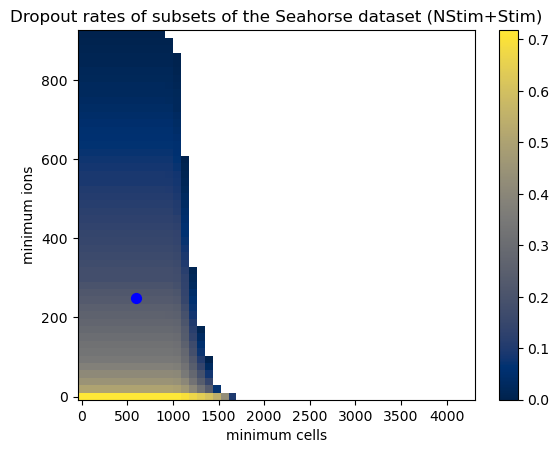

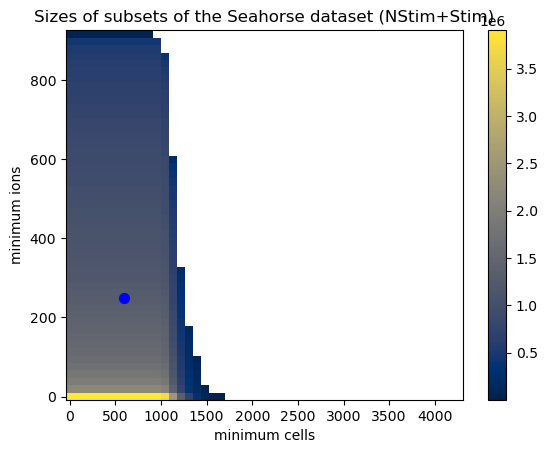

In [22]:
adata_s2c = datasets['Seahorse'].copy()
adata_s2c = adata_s2c[~adata_s2c.obs['well'].isin(['A3', 'G1', 'J2', 'E2', 'E3', 'E4'])]
adata_s2c = adata_s2c[adata_s2c.obs['dataset_0'].isin(['Stim', 'NStim'])]
sub_df_S2c, sub_df_wide_S2c, sub_df_poins_S2c = heatmap_subset_adata(adata_s2c, num_ions=50, num_cells=50)

cells_axis, ions_axis = np.meshgrid(sub_df_wide_S2c.index, sub_df_wide_S2c.columns)

fig, ax = plt.subplots(1,1)
pc = ax.pcolormesh(cells_axis, ions_axis, sub_df_wide_S2c.values, alpha=1, cmap="cividis")
fig.colorbar(pc)
ax.scatter(x=600,y=250, s=50, color='blue')
ax.set_xlabel('minimum cells')
ax.set_ylabel('minimum ions')
ax.set_title('Dropout rates of subsets of the Seahorse dataset (NStim+Stim)')
plt.show()

fig, ax = plt.subplots(1,1)
pc = ax.pcolormesh(cells_axis, ions_axis, sub_df_poins_S2c.values, alpha=1, cmap="cividis")
fig.colorbar(pc)
ax.scatter(x=600,y=250, s=50, color='blue')
ax.set_xlabel('minimum cells')
ax.set_ylabel('minimum ions')
ax.set_title('Sizes of subsets of the Seahorse dataset (NStim+Stim)')
plt.show()

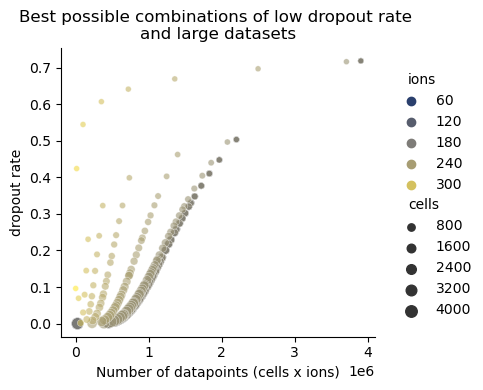

In [41]:
fig = sns.relplot(
    sub_df_S2c.reset_index().dropna(), x='n_points', y='dropout_ratio', hue='ions', size='cells', alpha=0.6, palette='cividis', height=4
)
fig.set(
    title='Best possible combinations of low dropout rate \nand large datasets', 
    xlabel='Number of datapoints (cells x ions)', 
    ylabel='dropout rate')
fig.tight_layout()

In [ ]:
sub_df_wide_S = heatmap_subset_adata(datasets['Seahorse'], num_ions=50, num_cells=50)

  0%|          | 0/50 [00:00<?, ?it/s]

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.


100%|██████████| 50/50 [00:01<00:00, 35.82it/s]


[Parallel(n_jobs=48)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=48)]: Done   3 out of  50 | elapsed:   14.3s remaining:  3.7min
[Parallel(n_jobs=48)]: Done   5 out of  50 | elapsed:   16.9s remaining:  2.5min
[Parallel(n_jobs=48)]: Done   7 out of  50 | elapsed:   31.4s remaining:  3.2min
[Parallel(n_jobs=48)]: Done   9 out of  50 | elapsed:   31.7s remaining:  2.4min
[Parallel(n_jobs=48)]: Done  11 out of  50 | elapsed:   31.9s remaining:  1.9min
[Parallel(n_jobs=48)]: Done  13 out of  50 | elapsed:   32.5s remaining:  1.5min
[Parallel(n_jobs=48)]: Done  15 out of  50 | elapsed:   33.2s remaining:  1.3min
[Parallel(n_jobs=48)]: Done  17 out of  50 | elapsed:   33.8s remaining:  1.1min
[Parallel(n_jobs=48)]: Done  19 out of  50 | elapsed:   34.1s remaining:   55.6s
[Parallel(n_jobs=48)]: Done  21 out of  50 | elapsed:   34.2s remaining:   47.3s
[Parallel(n_jobs=48)]: Done  23 out of  50 | elapsed:   34.3s remaining:   40.3s
[Parallel(n_jobs=48)]: Done  25 out of  50 | el

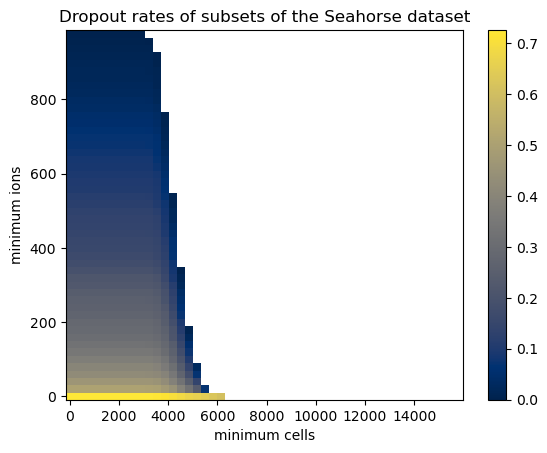

In [20]:
cells_axis, ions_axis = np.meshgrid(sub_df_wide_S.index, sub_df_wide_S.columns)

fig, ax = plt.subplots(1,1)
pc = ax.pcolormesh(cells_axis, ions_axis, sub_df_wide_S.values, alpha=1, cmap="cividis")
fig.colorbar(pc)
#ax.scatter(x=600,y=250, s=50, color='blue')
ax.set_xlabel('minimum cells')
ax.set_ylabel('minimum ions')
ax.set_title('Dropout rates of subsets of the Seahorse dataset')
plt.show()

In [ ]:
sub_df_G, sub_df_dr_G, sub_df_points_G = heatmap_subset_adata(datasets['Glioblastoma'], num_ions=50, num_cells=50, n_jobs=30)

cells_axis, ions_axis = np.meshgrid(sub_df_dr_G.index, sub_df_dr_G.columns)

fig, ax = plt.subplots(1,1)
pc = ax.pcolormesh(cells_axis, ions_axis, sub_df_wide_G.values, alpha=1, cmap="cividis")
fig.colorbar(pc)
ax.scatter(x=600,y=250, s=50, color='blue')
ax.set_xlabel('minimum cells')
ax.set_ylabel('minimum ions')
ax.set_title('Dropout rates of subsets of the Glioblastoma dataset')
plt.show()

fig, ax = plt.subplots(1,1)
pc = ax.pcolormesh(cells_axis, ions_axis, sub_df_points_G.values, alpha=1, cmap="cividis")
fig.colorbar(pc)
ax.scatter(x=600,y=250, s=50, color='blue')
ax.set_xlabel('minimum cells')
ax.set_ylabel('minimum ions')
ax.set_title('Sizes of subsets of the Glioblastoma dataset')
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.


100%|██████████| 50/50 [00:01<00:00, 37.47it/s]


[Parallel(n_jobs=48)]: Done   1 tasks      | elapsed:    8.2s
[Parallel(n_jobs=48)]: Done   3 out of  50 | elapsed:   10.2s remaining:  2.7min
[Parallel(n_jobs=48)]: Done   5 out of  50 | elapsed:   14.0s remaining:  2.1min
[Parallel(n_jobs=48)]: Done   7 out of  50 | elapsed:   15.7s remaining:  1.6min


In [6]:
sub_df_P, sub_df_dr_P, sub_df_points_P = heatmap_subset_adata(datasets['Pancreatic Cancer'], num_ions=50, num_cells=50, n_jobs=30)

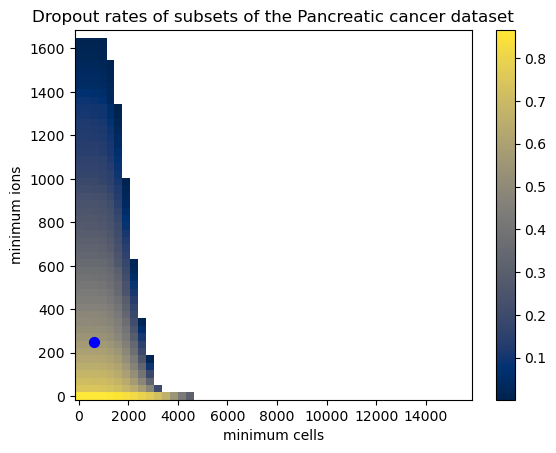

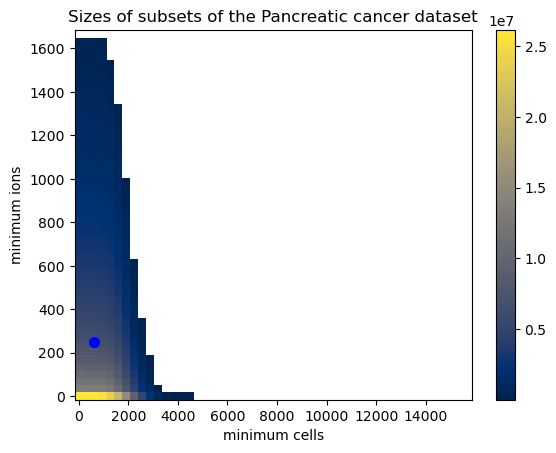

Global dropout rate: 56.30 Percent
Adata as shape (5112, 631) and n_points = 3225672


In [16]:
cells_axis, ions_axis = np.meshgrid(sub_df_dr_P.index, sub_df_dr_P.columns)
choose_cells=600
choose_ions=250
fig, ax = plt.subplots(1,1)
pc = ax.pcolormesh(cells_axis, ions_axis, sub_df_dr_P.values, alpha=1, cmap="cividis")
fig.colorbar(pc)
ax.scatter(x=600,y=250, s=50, color='blue')
ax.set_xlabel('minimum cells')
ax.set_ylabel('minimum ions')
ax.set_title('Dropout rates of subsets of the Pancreatic cancer dataset')
plt.show()

fig, ax = plt.subplots(1,1)
pc = ax.pcolormesh(cells_axis, ions_axis, sub_df_points_P.values, alpha=1, cmap="cividis")
fig.colorbar(pc)
ax.scatter(x=600,y=250, s=50, color='blue')
ax.set_xlabel('minimum cells')
ax.set_ylabel('minimum ions')
ax.set_title('Sizes of subsets of the Pancreatic cancer dataset')
plt.show()

adata = datasets['Pancreatic Cancer'].copy()
sc.pp.filter_cells(adata, min_genes=choose_ions)
sc.pp.filter_genes(adata, min_cells=choose_cells)
get_dropout_rate(adata)
print(f"Adata as shape {adata.shape} and n_points = {adata.shape[0]*adata.shape[1]}")

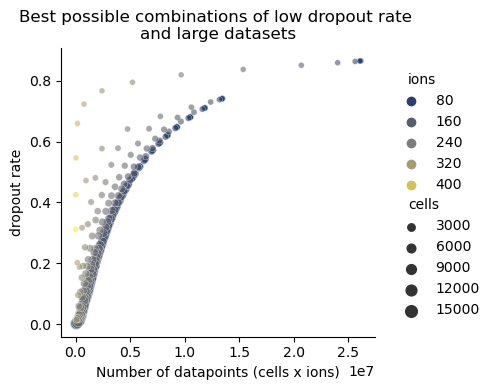

In [40]:
fig = sns.relplot(
    sub_df_P.reset_index().dropna(), x='n_points', y='dropout_ratio', hue='ions', size='cells', alpha=0.6, palette='cividis', height=4
)
fig.set(
    title='Best possible combinations of low dropout rate \nand large datasets', 
    xlabel='Number of datapoints (cells x ions)', 
    ylabel='dropout rate')
fig.tight_layout()

## Patterns of missing data

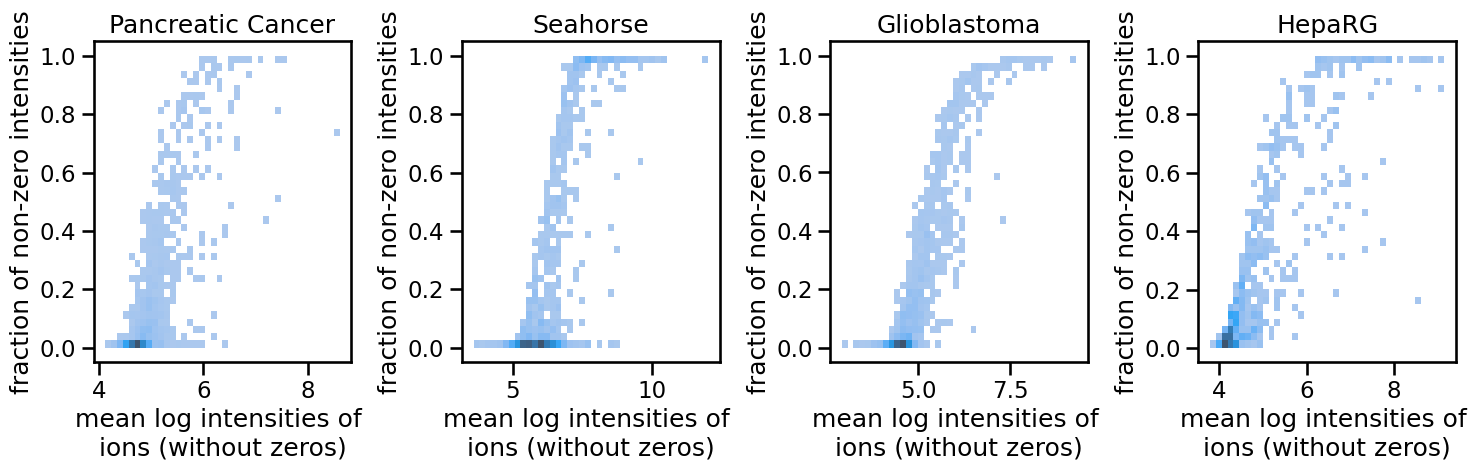

In [11]:
fig, ax = plt.subplots(1, len(datasets), figsize=(15, 5))

for i, name in enumerate(datasets):
    adata = datasets[name]
    adata.layers["ctrl"] = adata.layers["log_raw"].copy()
    adata.layers["ctrl"][adata.layers["ctrl"] == 0] = np.nan
    adata.var["mean_log_intensity_without_zero"] = np.nan_to_num(
        np.nanmean(adata.layers["ctrl"], axis=0)
    )

    #   adata.var['fraction_of_nonzero'] = np.log10(np.isnan(adata.layers["ctrl"]).sum(axis=0))
    adata.var["fraction_of_nonzero"] = (
        len(adata.obs_names) - np.isnan(adata.layers["ctrl"]).sum(axis=0)
    ) / len(adata.obs_names)
    pl = sns.histplot(
        adata.var,
        x="mean_log_intensity_without_zero",
        y="fraction_of_nonzero",
        bins=(40, 40),
        ax=ax[i],
    )
    pl.set_title(f"{name}")
    pl.set_xlabel(f"mean log intensities of \nions (without zeros)")
    pl.set_ylabel(f"fraction of non-zero intensities")


fig.tight_layout()
fig.savefig(os.path.join(save_to, "mean_log_intensity_without_zero.pdf"))

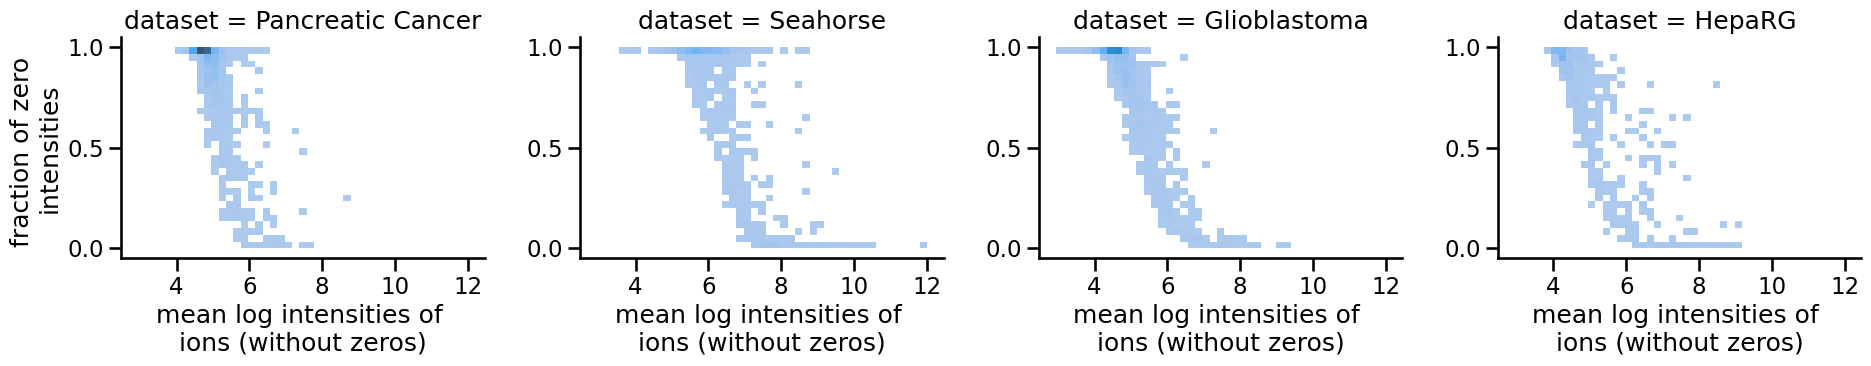

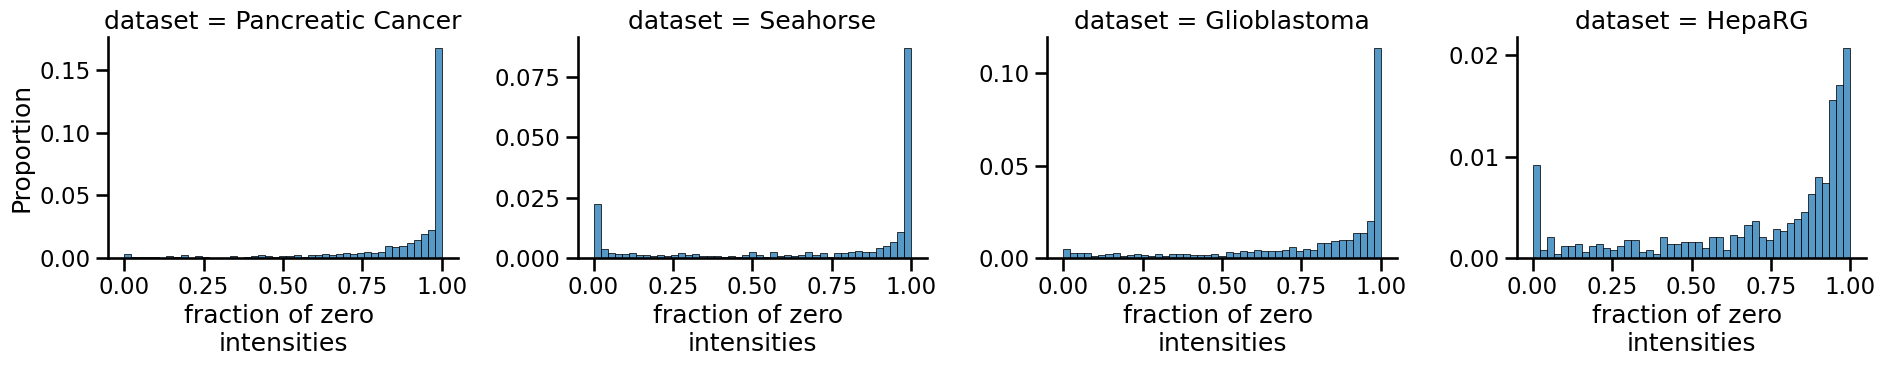

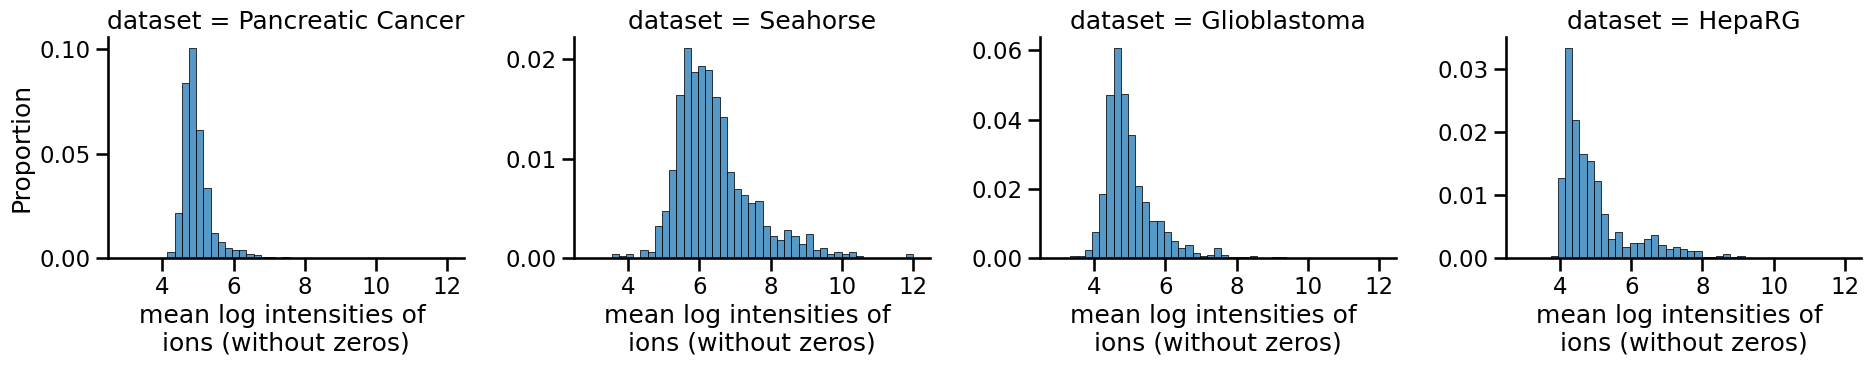

In [14]:
hist_list = []
for i, name in enumerate(datasets):
    adata = datasets[name]
    adata.layers["ctrl"] = adata.layers["log_raw"].copy()
    adata.layers["ctrl"][adata.layers["ctrl"] == 0] = np.nan
    adata.var["mean_log_intensity_without_zero"] = np.nan_to_num(
        np.nanmean(adata.layers["ctrl"], axis=0)
    )

    adata.var["fraction_of_zeros"] = 1 - (
        len(adata.obs_names) - np.isnan(adata.layers["ctrl"]).sum(axis=0)
    ) / len(adata.obs_names)
    adata.var["dataset"] = name
    hist_list.append(adata.var)

hist_df = pd.concat(hist_list)

pl = sns.displot(
    data=hist_df.reset_index(),
    x="mean_log_intensity_without_zero",
    y="fraction_of_zeros",
    col="dataset",  # col_wrap=2,
    bins=(45, 30),
    height=4,
    aspect=1.2,
    facet_kws=dict(sharey=False),
)

pl.set_xlabels(f"mean log intensities of \nions (without zeros)")
pl.set_ylabels(f"fraction of zero \nintensities")
pl.tight_layout()
pl.savefig(os.path.join(save_to, "rel_dr_mean_intensity.pdf"))

pl = sns.displot(
    hist_df,
    stat="proportion",
    x="fraction_of_zeros",
    col="dataset",  # col_wrap=2,
    height=4,
    bins=45,
    aspect=1.2,
    facet_kws=dict(sharey=False),
)

pl.set_xlabels(f"fraction of zero \nintensities")
pl.tight_layout()
pl.savefig(os.path.join(save_to, "rel_dr_mean_intensity_hist_dr.pdf"))

pl = sns.displot(
    hist_df,
    stat="proportion",
    x="mean_log_intensity_without_zero",
    col="dataset",  # col_wrap=2,
    height=4,
    bins=45,
    aspect=1.2,
    facet_kws=dict(sharey=False),
)

pl.set_xlabels(f"mean log intensities of \nions (without zeros)")
pl.tight_layout()
pl.savefig(os.path.join(save_to, "rel_dr_mean_intensity_hist_intensity.pdf"))

In [15]:
def cv(x):
    return np.std(x) / np.mean(x) * 100


dr_var_list = []

for name, adata in datasets.items():
    dic = dict(name=name)
    dic["conditions"] = get_dropout_rate(adata, groupby=["condition"]).agg(cv)[0]
    dic["wells"] = get_dropout_rate(adata, groupby=["well"]).agg(cv)[0]
    dr_var_list.append(dic)

dr_var_df = pd.DataFrame(dr_var_list)
dr_var_df

Global dropout rate:  86.57%
Global dropout rate:  86.57%
Global dropout rate:  71.27%
Global dropout rate:  71.27%
Global dropout rate:  79.01%
Global dropout rate:  79.01%
Global dropout rate:  71.07%
Global dropout rate:  71.07%


name  conditions     wells
0  Pancreatic Cancer    1.243631  2.585496
1           Seahorse    2.643007  2.961667
2       Glioblastoma    4.766128  5.894639
3             HepaRG    3.161581  4.354439

In [84]:
adata = datasets['Seahorse'].copy()
adata = adata[~adata.obs['well'].isin(['A3', 'G1', 'J2', 'E2', 'E3', 'E4'])]
#adata = adata[adata.obs['condition'].isin(['Stim', 'NStim'])]

Despite the different dropout ratios across wells (following table), here are also differences in missing patterns. Some ions have a very uniform dropout ratio across wells, but few ions show large differences between wells (high variance in the plot below)

[Text(0.5, 1.0, 'Distribution of variances of dropout ratios across wells'),
 Text(0.5, 0, 'Variance')]

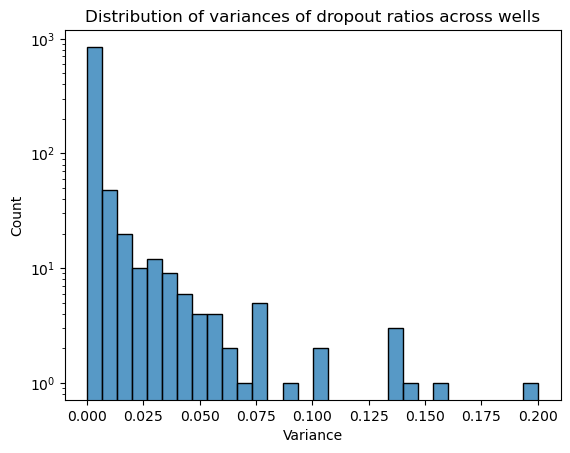

In [21]:
zero_prevalence_variance = sc.get.obs_df(
    adata, 
    keys=list(adata.var_names) + ["well"], 
    layer="zero_mask").groupby("well").mean().var().sort_values()
sns.histplot(
    zero_prevalence_variance, 
    bins=30, 
    log_scale=(False, True)).set(title="Distribution of variances of dropout ratios across wells",
                                 xlabel="Variance")

This can be shown in the histograms of the corresponding ions. The two left ions have different dropout ratios across wells, while the right ions have very uniform dropout ratios

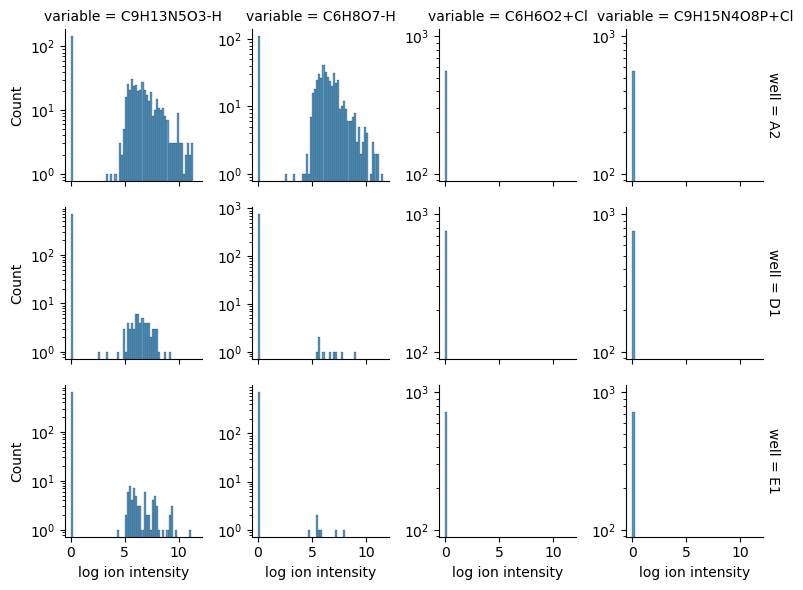

In [22]:
incl_wells = ['A2', 'D1', 'E1']
sns.displot(sc.get.obs_df(
        adata[adata.obs['well'].isin(incl_wells)], 
        keys=list(zero_prevalence_variance.tail(2).index) +
            list(zero_prevalence_variance.head(2).index)+ ["well"], 
        layer="log_raw").reset_index().melt(id_vars=["cell_id", "well"]), 
    x='value', 
    col='variable', 
    row="well",
    kind="hist",
    bins=60,
    log_scale=(False, True),
    height=2,
    facet_kws={'margin_titles':True, 'sharey':False}
    ).set(xlabel="log ion intensity")

In [103]:
import random
import matplotlib.colors as mcolors

var_display_names = {
    'layer': 'imputation',
    'corr_method': 'correlation',
    'network_type': 'correlation scaling',
    'network_name': 'thresholding',
    'community_type': 'community detection',
    'well': "replicate",
    'condition': "condition",

}
def get_random_colors(strings, randomSeed=123):
    # Define a list of well-distinguishable colors
    colors = list(mcolors.CSS4_COLORS.keys())

    # Shuffle the colors randomly
    random.seed(randomSeed)
    random.shuffle(colors)

    # Return a list of named colors, one for each string
    return [colors[i % len(colors)] for i in range(len(strings))]


def get_random_colors_clustmap(vars, dataframe, index = None):
    row_colors = {}
    luts = {}
    for i, var in enumerate(vars):
        lut = dict(zip(dataframe[var].unique(), get_random_colors(dataframe[var].unique(), randomSeed=10+i)))
            
        luts[var_display_names[var]] = lut
        row_colors[var_display_names[var]] = dataframe[var].map(lut)
    colors_df = pd.concat(row_colors, axis=1)
    if index is not None:
        colors_df.index = index
    colors_df = colors_df.loc[~colors_df.index.duplicated()]
    return colors_df, luts

cond_colors, lut = get_random_colors_clustmap(
    vars = ['condition'], 
    dataframe = adata.obs, 
    index = adata.obs['well']
)

cond_colors

condition
well                
B3         royalblue
B4    lightsteelblue
A2     palegoldenrod
D1         cadetblue
H4    lightsteelblue
H3         royalblue
F4    lightsteelblue
F3         royalblue
F2     palegoldenrod
C1         cadetblue
B1         cadetblue
G4    lightsteelblue
E1         cadetblue

In [112]:
import matplotlib.text as mtext

def add_legend_to_clustermap(clustermap, color_luts):
    ax = clustermap.fig.add_axes((1,1,0, 0))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    class LegendTitle(object):
        def __init__(self, text_props=None):
            self.text_props = text_props or {}
            super(LegendTitle, self).__init__()

        def legend_artist(self, legend, orig_handle, fontsize, handlebox):
            x0, y0 = handlebox.xdescent, handlebox.ydescent
            title = mtext.Text(x0, y0, orig_handle,  **self.text_props)
            handlebox.add_artist(title)
            return title


    handles = []
    labels = []
    for i, (var, values) in enumerate(color_luts.items()):
        if i != 0:
            handles.append('')
            labels.append('')
        handles.append(var)
        labels.append('')
        for key, color in values.items():
            # legend_elements.append(sns.patches.Patch(facecolor=color, label=key))
            handles.append(plt.Rectangle((0, 0), 1, 1, color=color, label=key))
            labels.append(key)

    ax.legend(
        handles=handles, 
        labels=labels, 
        loc="upper left", 
        handler_map={str: LegendTitle({'fontsize': 12})},
        bbox_to_anchor=(1, 1)
    )

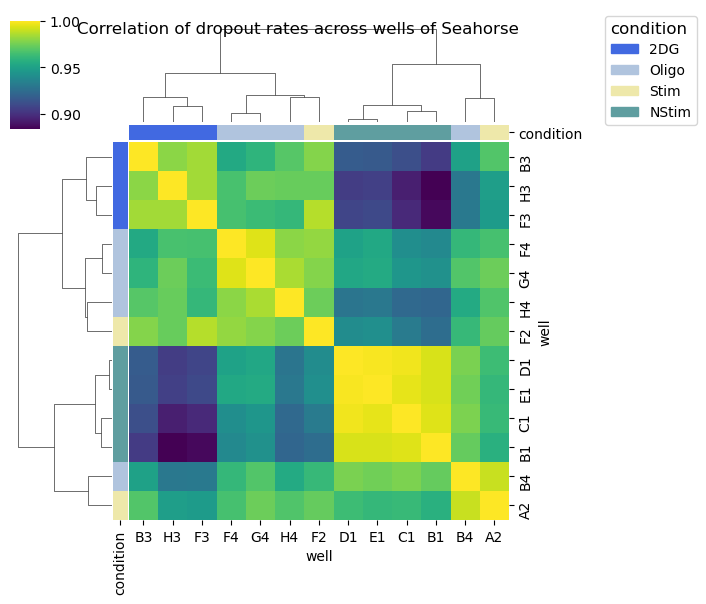

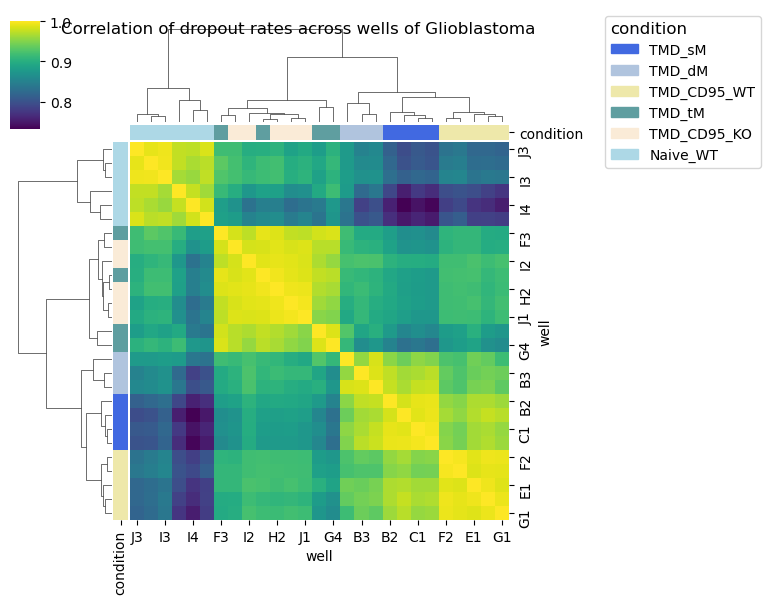

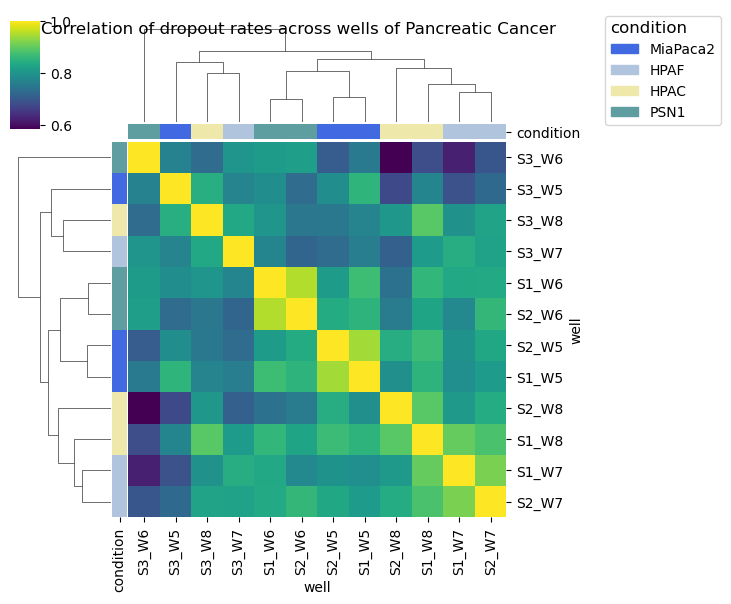

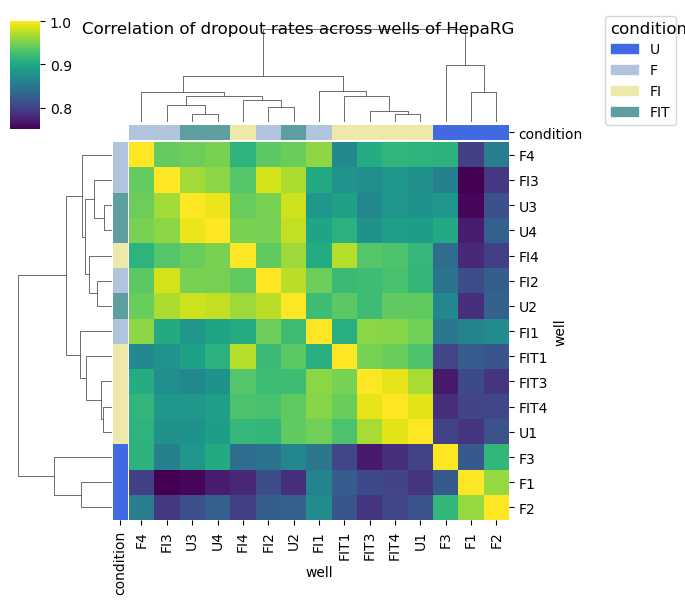

In [113]:
for name, adata in datasets.items():

    cond_colors, lut = get_random_colors_clustmap(
        vars = ['condition'], 
        dataframe = adata.obs, 
        index = adata.obs['well']
    )

    corr_df = sc.get.obs_df(
        adata, 
        keys=['condition', 'well'] + adata.var_names.tolist()
    ).set_index(
        ['condition', 'well'], 
        append=True
    ).groupby('well').agg(lambda x: len(x[x==0]) / len(x)).T.corr()

    plot = sns.clustermap(
        corr_df, 
        cmap='viridis', 
        figsize=(6, 6), 
        row_colors=cond_colors, 
        col_colors=cond_colors
    )
    add_legend_to_clustermap(plot, lut)
    plot.fig.suptitle(f"Correlation of dropout rates \nacross wells of {name}")

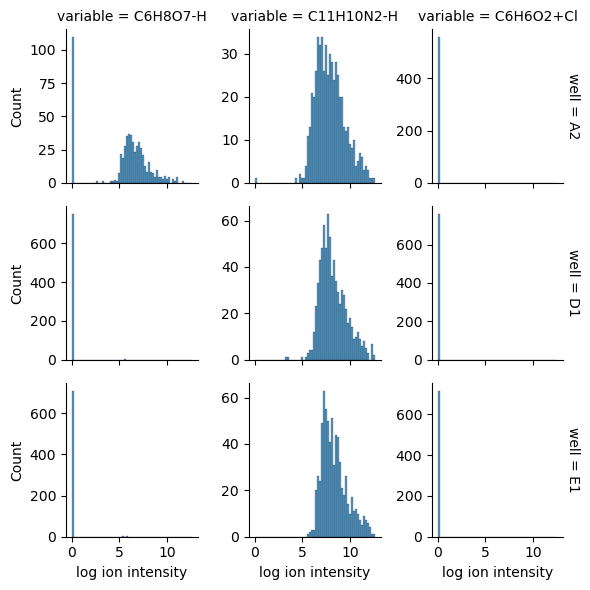

In [27]:
incl_wells = ['A2', 'D1', 'E1']
sns.displot(sc.get.obs_df(
        adata[adata.obs['well'].isin(incl_wells)], 
        keys=list(zero_prevalence_variance.tail(1).index) + [zero_prevalence_variance.index[170]] +
            list(zero_prevalence_variance.head(1).index)+ ["well"], 
        layer="log_raw").reset_index().melt(id_vars=["cell_id", "well"]), 
    x='value', 
    col='variable', 
    row="well",
    kind="hist",
    bins=60,
    log_scale=(False, False),
    height=2,
    facet_kws={'margin_titles':True, 'sharey':False}
    ).set(xlabel="log ion intensity")

## Simulating dropouts on top of that

Seahorse dataset has the least dropouts initially, carryig on with that

you have 17048 data points. sampling down to 100k
you have 17048 data points. sampling down to 100k
you have 17048 data points. sampling down to 100k
you have 17048 data points. sampling down to 100k
Global dropout rate: 80.89 Percent
Global dropout rate: 90.00 Percent
Global dropout rate: 90.00 Percent


0.9000469263256687

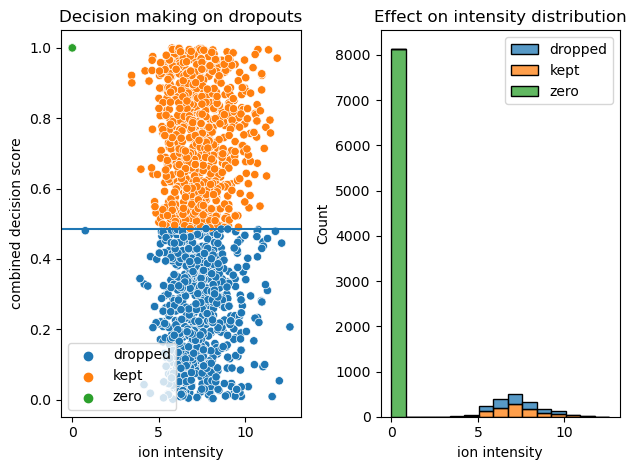

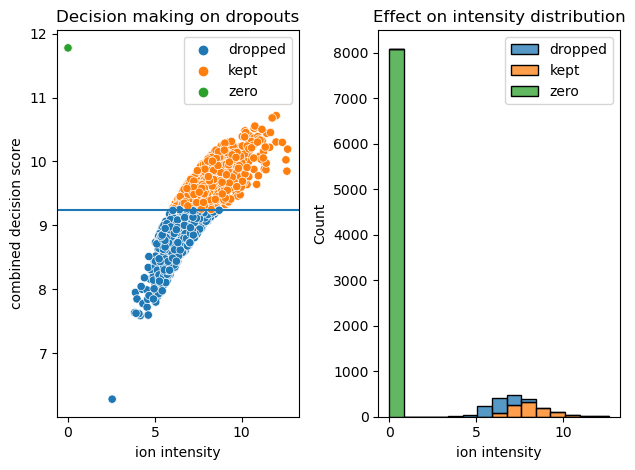

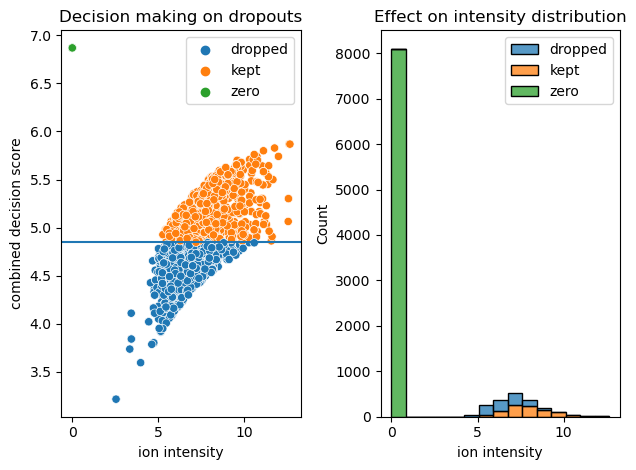

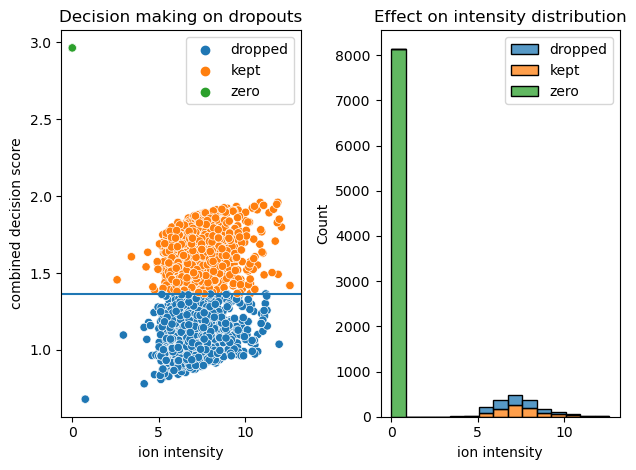

In [33]:

mask_test = sc.get.obs_df(
        adata, 
        keys=list(zero_prevalence_variance.tail(2).index) +
             list(zero_prevalence_variance.head(2).index) + ["well"], 
        layer="log_raw").reset_index().melt(id_vars=["cell_id", "well"])

mask_test['mcar_simulated_dropouts'], mask_test['mcar_dropout_mask'] = simulate_dropouts_mcar_array(np.array(mask_test['value']), rate=0.9, return_mask=True)
mask_test['mnar_simulated_dropouts'], mask_test['mnar_dropout_mask'] = simulate_dropouts_mnar_array(np.array(mask_test['value']), rate=0.9, value_importance=10, return_mask=True)
_ = simulate_dropouts_mnar_array(np.array(mask_test['value']), rate=0.9, value_importance=5)
_ = simulate_dropouts_mnar_array(np.array(mask_test['value']), rate=0.9, value_importance=1)

calculate_dropout_rate_array(mask_test['value'])
calculate_dropout_rate_array(mask_test['mnar_simulated_dropouts'])
calculate_dropout_rate_array(mask_test['mcar_simulated_dropouts'])

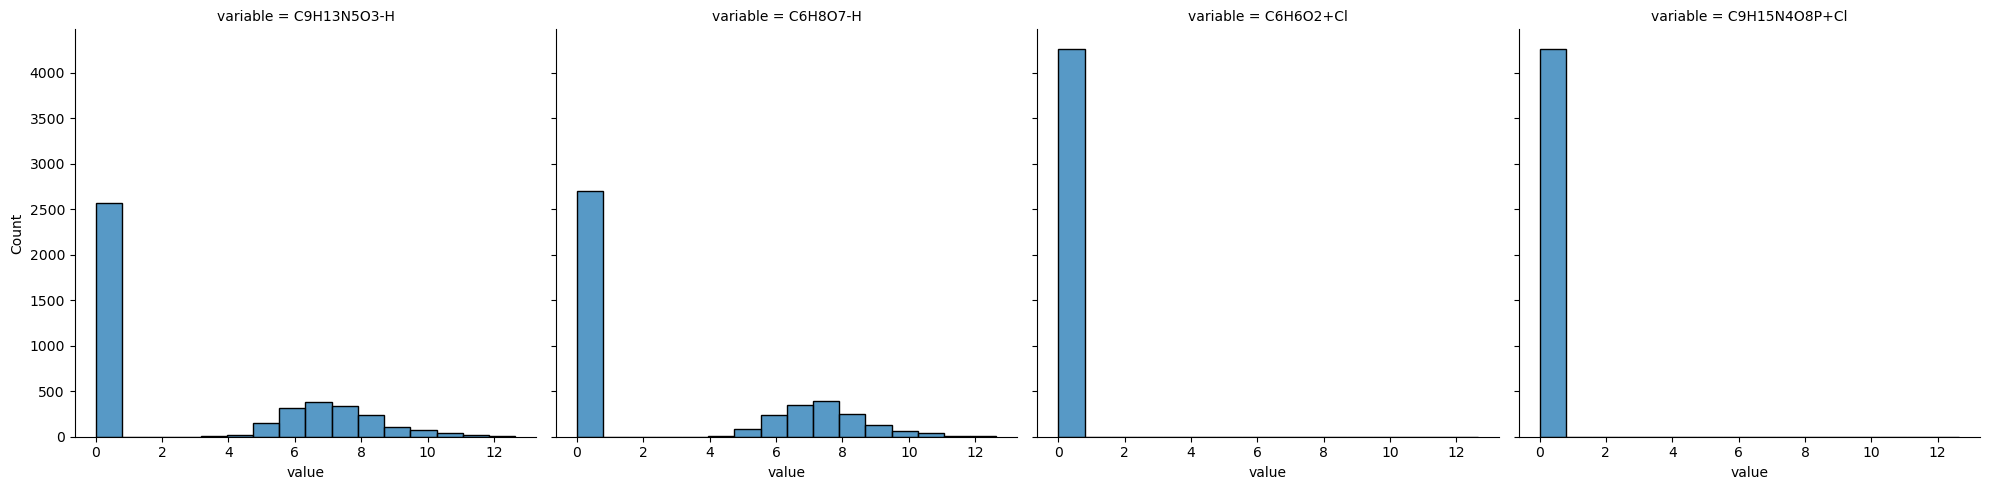

In [ ]:
sns.displot(mask_test, x='value', col='variable')

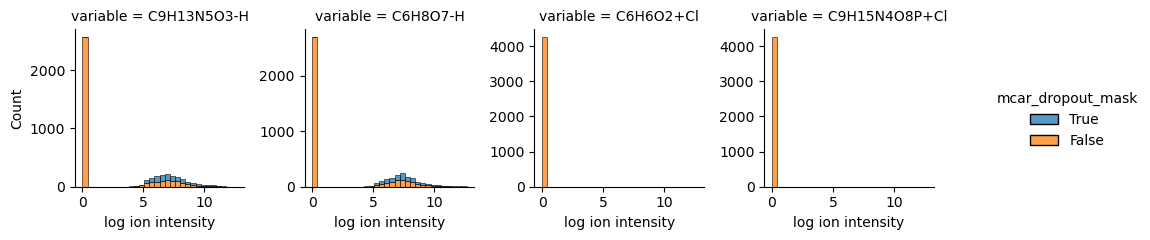

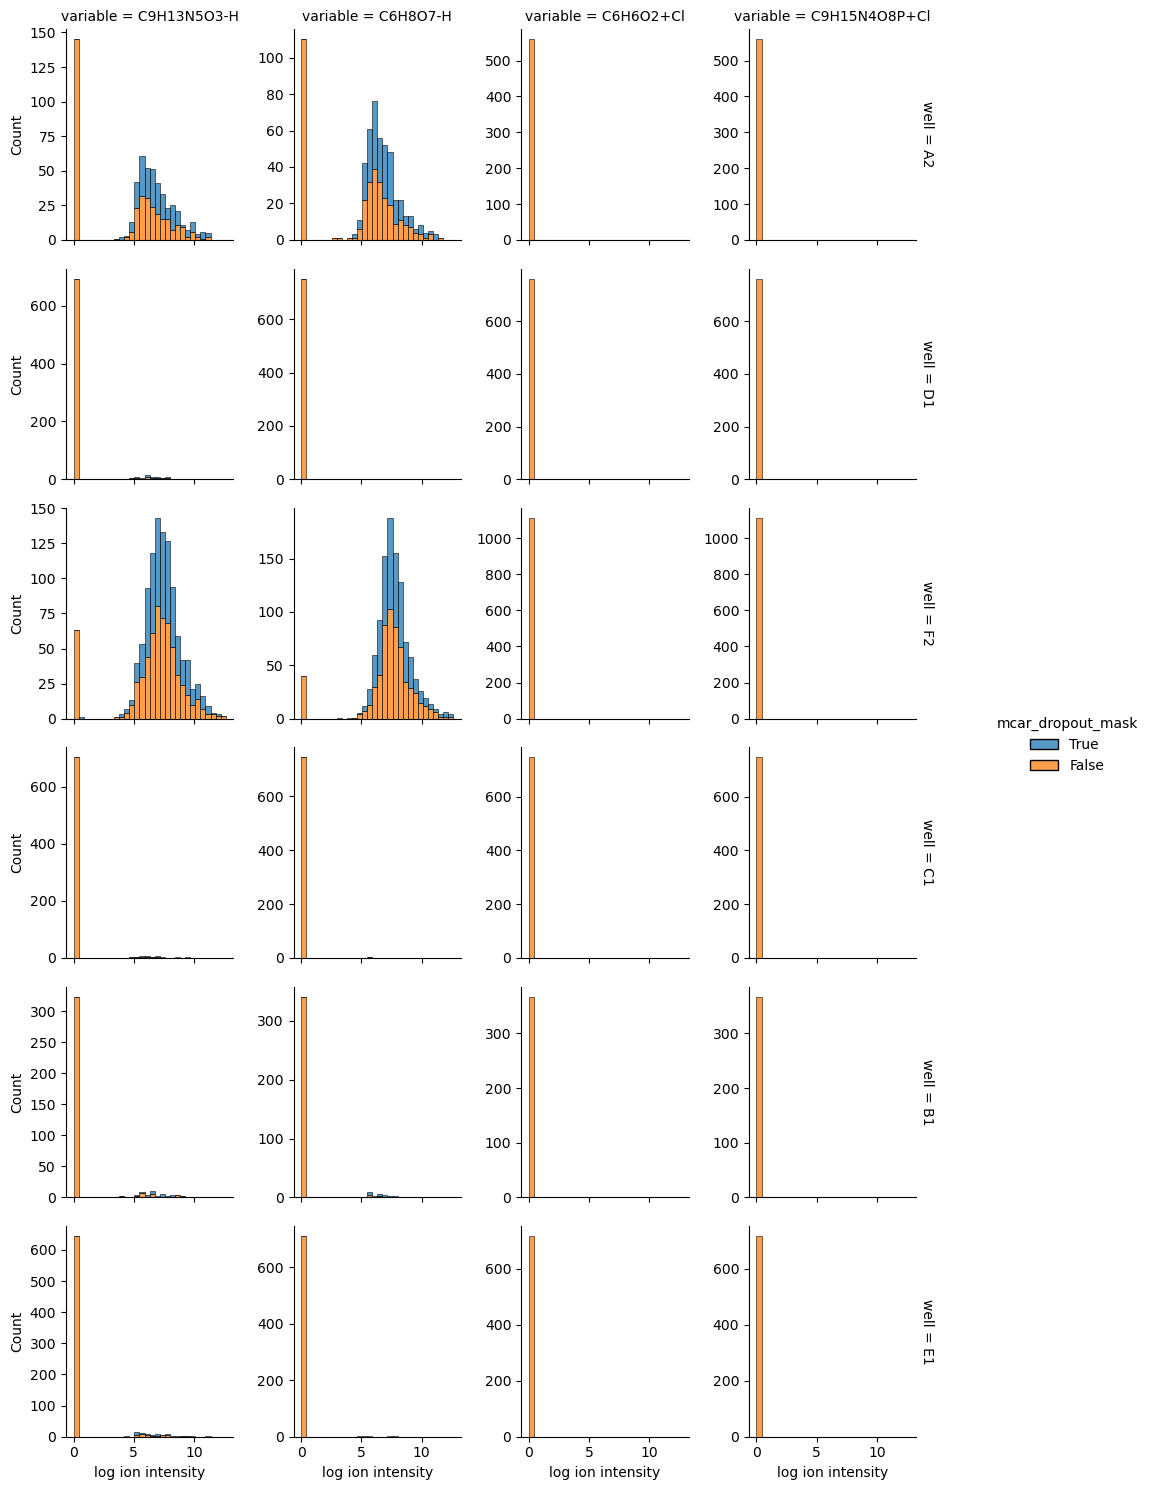

In [34]:
sns.displot(mask_test, 
    x='value', 
    col='variable', 
    hue='mcar_dropout_mask',
    hue_order=[True, False],
    kind="hist",
    bins=30,
    log_scale=(False, False),
    height=2.5,
    multiple='stack',
    facet_kws={'margin_titles':True, 'sharey':False}
    ).set(xlabel="log ion intensity")

sns.displot(mask_test, 
    x='value', 
    col='variable', 
    hue='mcar_dropout_mask',
    hue_order=[True, False],
    row="well",
    kind="hist",
    bins=30,
    log_scale=(False, False),
    height=2.5,
    multiple='stack',
    facet_kws={'margin_titles':True, 'sharey':False}
    ).set(xlabel="log ion intensity")

# mask_test[['well', 'mcar_simulated_dropouts']].groupby('well').agg(lambda x: calculate_dropout_rate_array(x, v=False))

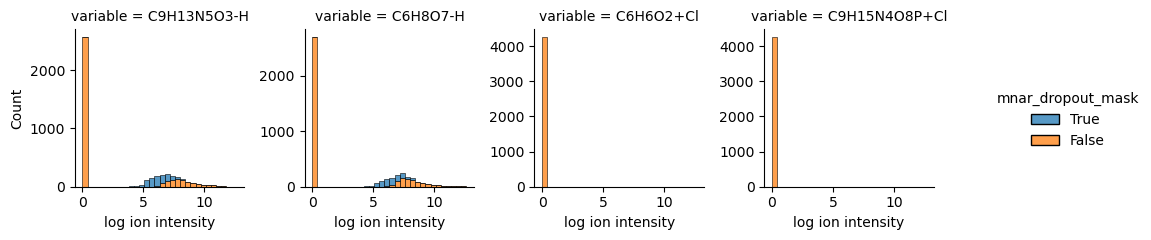

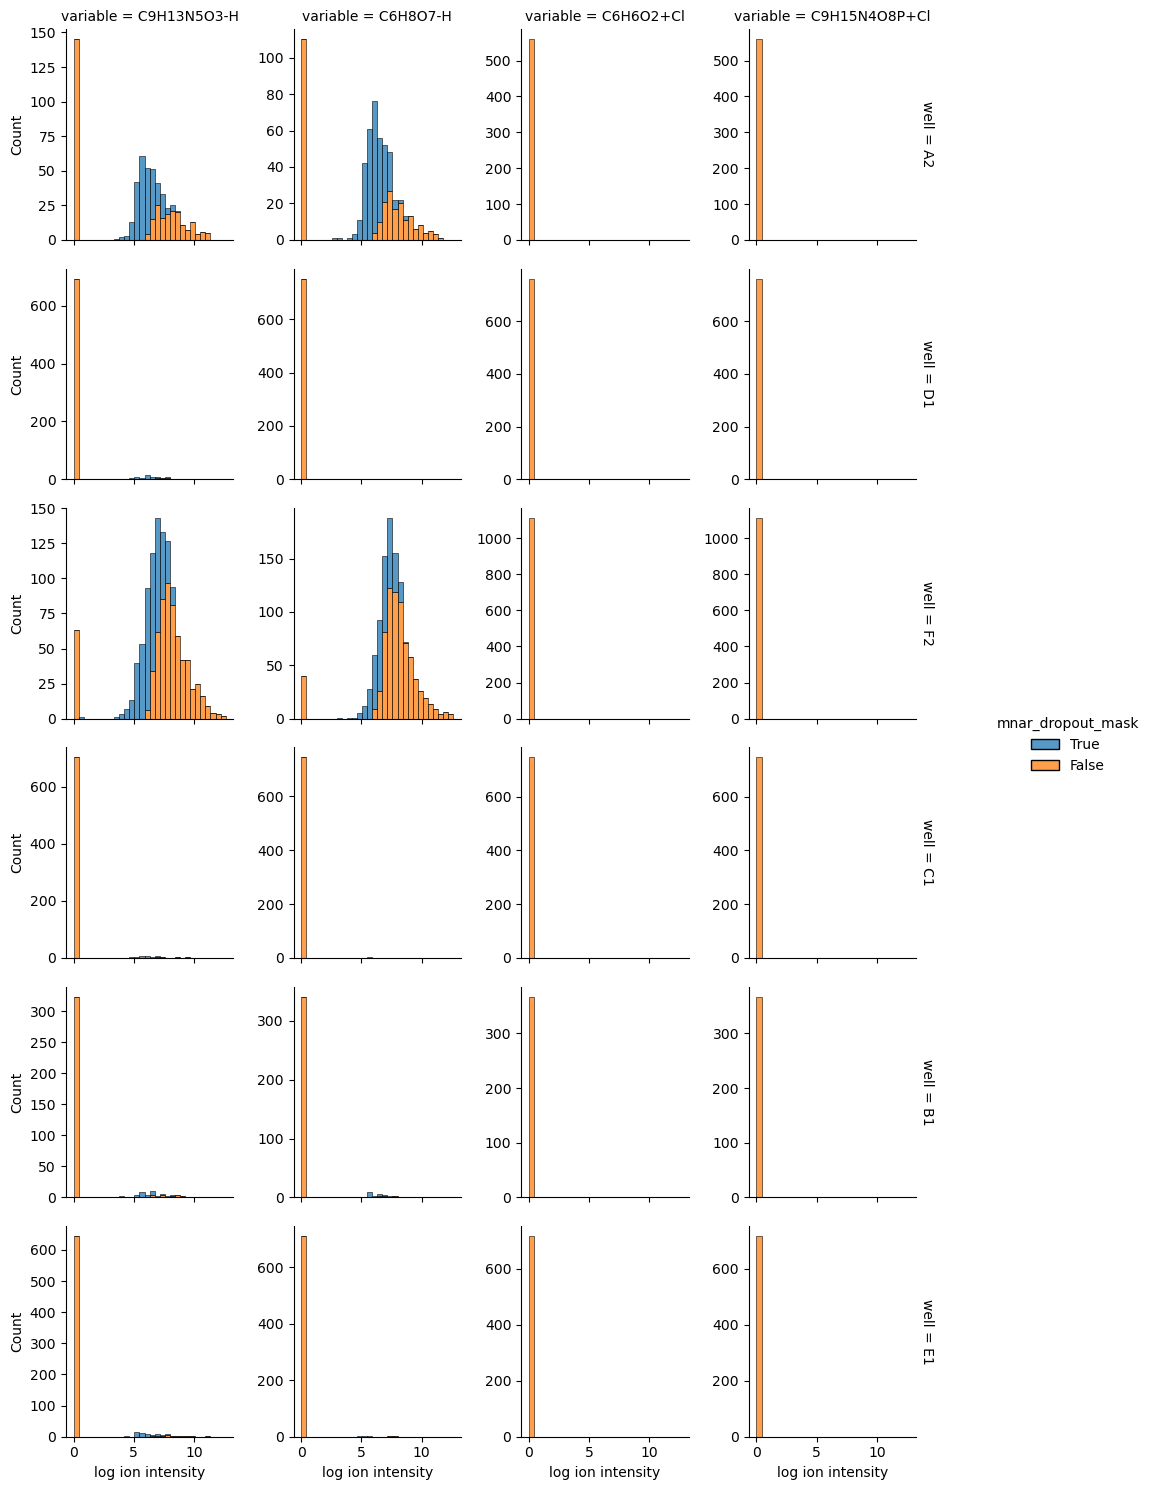

In [35]:
sns.displot(mask_test, 
    x='value', 
    col='variable', 
    hue='mnar_dropout_mask',
    hue_order=[True, False],
    kind="hist",
    bins=30,
    log_scale=(False, False),
    height=2.5,
    multiple='stack',
    facet_kws={'margin_titles':True, 'sharey':False}
    ).set(xlabel="log ion intensity")

sns.displot(mask_test, 
    x='value', 
    col='variable', 
    hue='mnar_dropout_mask',
    hue_order=[True, False],
    row="well",
    kind="hist",
    bins=30,
    log_scale=(False, False),
    height=2.5,
    multiple='stack',
    facet_kws={'margin_titles':True, 'sharey':False}
    ).set(xlabel="log ion intensity")

#mask_test[['well', 'mnar_simulated_dropouts']].groupby('well').agg(lambda x: calculate_dropout_rate_array(x, v=False))

you have 15447347 data points. sampling down to 100k
Seahorse
Global dropout rate: 95.00 Percent
        dropout_ratio
sample               
A3           0.948368
G1           0.952227
B3           0.944708
B4           0.953777
A2           0.950987
D1           0.953306
H4           0.948813
H3           0.943811
E2           0.953683
F4           0.947326
F3           0.944847
F2           0.947168
E3           0.953833
E4           0.955829
C1           0.954104
B1           0.954348
G4           0.948529
E1           0.953592
J2           0.953832
you have 20687292 data points. sampling down to 100k
Glioblastoma
Global dropout rate: 95.00 Percent
        dropout_ratio
sample               
B4           0.984450
C1           0.954687
B1           0.964357
D2           0.954112
C4           0.981067
B2           0.956706
C2           0.956516
B3           0.958692
C3           0.954217
D1           0.949081
D3           0.947171
D4           0.978389
E1           0.950804
E2        

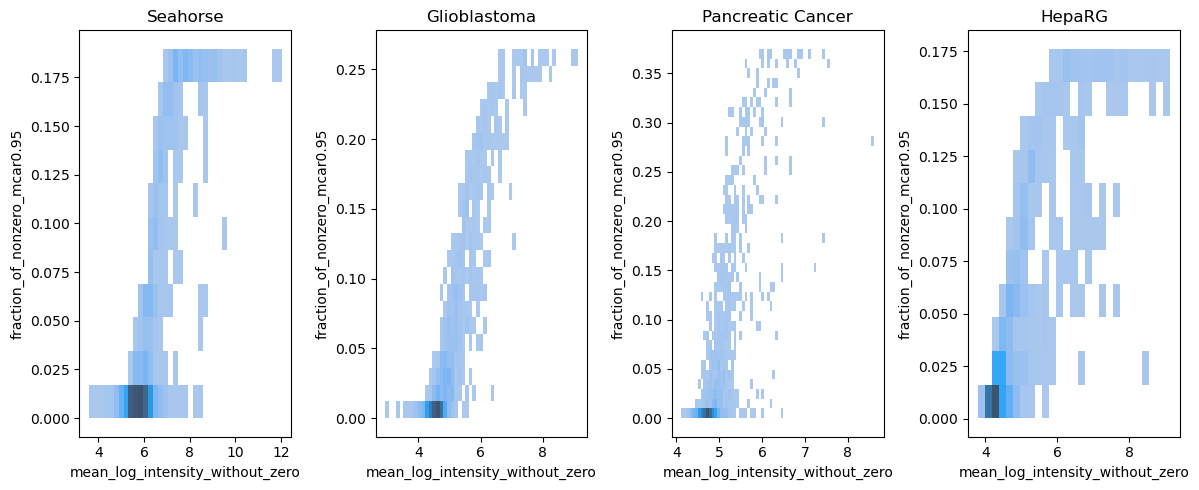

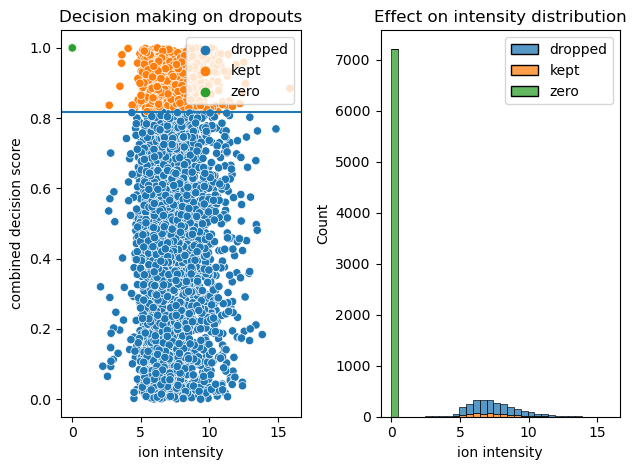

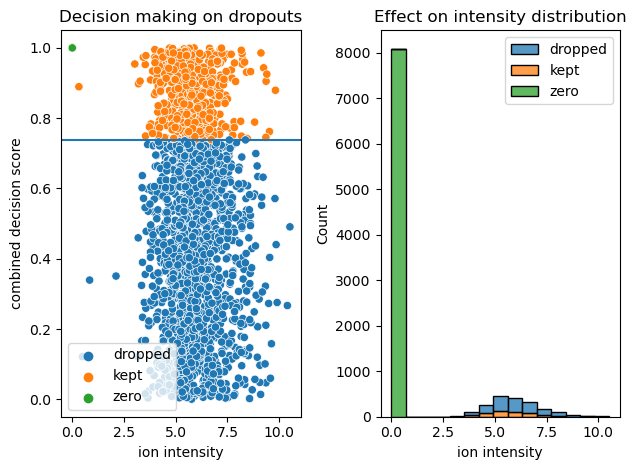

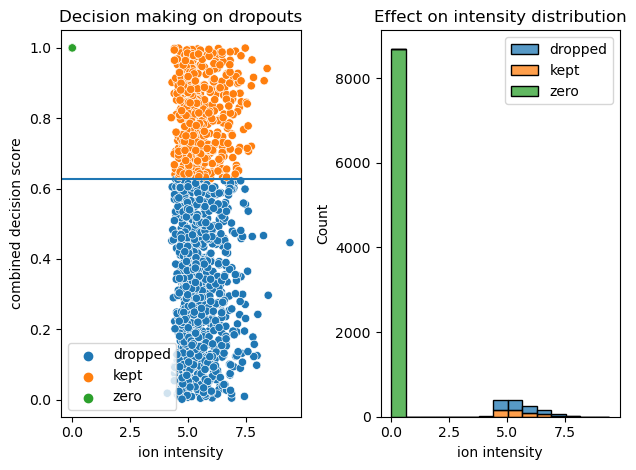

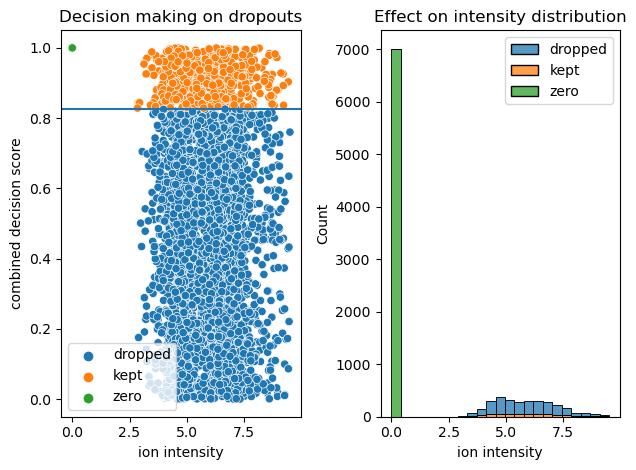

In [49]:
fig, ax = plt.subplots(1, len(datasets), figsize=(12, 5))
dr = 0.95
for i, name in enumerate(datasets):
    adata = datasets[name]
    
    adata.layers[f"mcar={dr}"] = simulate_dropouts_mcar_array(adata.layers['log_raw'], rate=dr)
    print(name)
    print(get_dropout_rate(adata, layer=f"mcar={dr}", groupby='sample'))
    adata.layers[f"mcar={dr}"][adata.layers[f"mcar={dr}"] == 0] = np.nan
    
    adata.var[f'fraction_of_nonzero_mcar{dr}'] = (len(adata.obs_names) - np.isnan(adata.layers[f"mcar={dr}"]).sum(axis=0)) / len(adata.obs_names)
    sns.histplot(data=adata.var, 
                 x=f'mean_log_intensity_without_zero',
                 y=f'fraction_of_nonzero_mcar{dr}',
                 ax=ax[i],
                ).set_title(f"{name}")

    
    
    
fig.tight_layout()

In [50]:
hist_list = []
for i, name in enumerate(datasets):
    adata = datasets[name]
    adata.layers['ctrl'] = adata.layers['log_raw'].copy()
    adata.X = adata.layers['ctrl']
    wflow = evaluation_workflow(adata = adata)
    for method in ['mcar', 'mnar']:
        wflow.simulate_dropouts(dropout_rates = [0.9, 0.95], method=method)
        for dr in wflow.dataset_dict.keys():
            adata = wflow.dataset_dict[dr]
            df = adata.var.copy()
            adata.layers['ctrl'][adata.layers['ctrl'] == 0] = np.nan
            df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))
            df['fraction_of_zeros'] =  1 - (len(adata.obs_names) - np.isnan(adata.layers["ctrl"]).sum(axis=0)) / len(adata.obs_names)
            df['dataset'] = name
            rate = 'baseline' if 'baseline' in str(dr) else str(dr)
            df['dr'] = rate
            df['dropout_ratio'] = f"{rate} ({method})"
            df['method'] = method
            hist_list.append(df)
            adata.layers['ctrl'][np.isnan(adata.layers['ctrl'])] = 0

hist_df = pd.concat(hist_list).reset_index()
hist_backup = hist_df.copy()
hist_df

IE version 1.2
IE version 1.2
Global dropout rate: 72.54 Percent
simulating dropout rates [0.7253602835490134, 0.9, 0.95] with method mcar


/tmp/ipykernel_113/625579725.py:17: RuntimeWarning: Mean of empty slice
  df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))
/tmp/ipykernel_113/625579725.py:17: RuntimeWarning: Mean of empty slice
  df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))


simulating dropout rates [0.7253602835490134, 0.9, 0.95] with method mnar


/tmp/ipykernel_113/625579725.py:17: RuntimeWarning: Mean of empty slice
  df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))
/tmp/ipykernel_113/625579725.py:17: RuntimeWarning: Mean of empty slice
  df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))


Global dropout rate: 80.88 Percent
simulating dropout rates [0.8088245189365529, 0.9, 0.95] with method mcar


/tmp/ipykernel_113/625579725.py:17: RuntimeWarning: Mean of empty slice
  df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))
/tmp/ipykernel_113/625579725.py:17: RuntimeWarning: Mean of empty slice
  df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))


simulating dropout rates [0.8088245189365529, 0.9, 0.95] with method mnar


/tmp/ipykernel_113/625579725.py:17: RuntimeWarning: Mean of empty slice
  df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))
/tmp/ipykernel_113/625579725.py:17: RuntimeWarning: Mean of empty slice
  df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))


Global dropout rate: 86.57 Percent
simulating dropout rates [0.8656951810148013, 0.9, 0.95] with method mcar


/tmp/ipykernel_113/625579725.py:17: RuntimeWarning: Mean of empty slice
  df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))
/tmp/ipykernel_113/625579725.py:17: RuntimeWarning: Mean of empty slice
  df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))


simulating dropout rates [0.8656951810148013, 0.9, 0.95] with method mnar


/tmp/ipykernel_113/625579725.py:17: RuntimeWarning: Mean of empty slice
  df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))
/tmp/ipykernel_113/625579725.py:17: RuntimeWarning: Mean of empty slice
  df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))


Global dropout rate: 71.07 Percent
simulating dropout rates [0.7106984329813706, 0.9, 0.95] with method mcar
supplied adata has raw attribute. Simulating dropouts here aswell. You can preven this by setting argument simulate_raw=False
supplied adata has raw attribute. Simulating dropouts here aswell. You can preven this by setting argument simulate_raw=False
supplied adata has raw attribute. Simulating dropouts here aswell. You can preven this by setting argument simulate_raw=False
simulating dropout rates [0.7106984329813706, 0.9, 0.95] with method mnar
supplied adata has raw attribute. Simulating dropouts here aswell. You can preven this by setting argument simulate_raw=False
supplied adata has raw attribute. Simulating dropouts here aswell. You can preven this by setting argument simulate_raw=False
supplied adata has raw attribute. Simulating dropouts here aswell. You can preven this by setting argument simulate_raw=False


/tmp/ipykernel_113/625579725.py:17: RuntimeWarning: Mean of empty slice
  df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))
/tmp/ipykernel_113/625579725.py:17: RuntimeWarning: Mean of empty slice
  df['mean_log_intensity_without_zero'] = np.nan_to_num(np.nanmean(adata.layers['ctrl'], axis=0))


index   annotation_id      formula adduct ionFormula  \
0           C2H2O4+Cl       C2H2O4+Cl       C2H2O4    +Cl   C2H2O4Cl   
1          C2H5O5P+Cl      C2H5O5P+Cl      C2H5O5P    +Cl  C2H5O5PCl   
2           C2H5O5P-H       C2H5O5P-H      C2H5O5P     -H    C2H4O5P   
3          C2H5O6P+Cl      C2H5O6P+Cl      C2H5O6P    +Cl  C2H5O6PCl   
4           C2H5O6P-H       C2H5O6P-H      C2H5O6P     -H    C2H4O6P   
...               ...             ...          ...    ...        ...   
29317  C63H112O10P+Na  C63H112O10P+Na  C63H112O10P    +Na        NaN   
29318   C63H114NO8P+K   C63H114NO8P+K  C63H114NO8P     +K        NaN   
29319  C63H114O10P+Na  C63H114O10P+Na  C63H114O10P    +Na        NaN   
29320     C64H106O6+K     C64H106O6+K    C64H106O6     +K        NaN   
29321     C66H104O6+K     C66H104O6+K    C66H104O6     +K        NaN   

               ion          mz  msm  fdr  \
0       C2H2O4+Cl-  124.964671  0.0  NaN   
1      C2H5O5P+Cl-  174.956822  0.0  NaN   
2       C2H5O5P-H-  138.980144  0.0  NaN   
3      C2H5O6P+Cl-  190.951736  0.0  NaN   
4       C2H5O6P-H-  154.975059  0.0  NaN   
...            ...         ...  ...  ...   
29317          NaN         NaN  NaN  NaN   
29318          NaN         NaN  NaN  NaN   
29319          NaN         NaN  NaN  NaN   
29320          NaN         NaN  NaN  NaN   
29321          NaN         NaN  NaN  NaN   

                                               databases  ...  \
0                 [["AB_tcells_ht_nedc_union_DB", "v1"]]  ...   
1      [["AB_Hiemer_Luisa_tcells_customdb", "v1"], ["...  ...   
2      [["AB_Hiemer_Luisa_tcells_customdb", "v1"], ["...  ...   
3                 [["AB_tcells_ht_nedc_union_DB", "v1"]]  ...   
4                 [["AB_tcells_ht_nedc_union_DB", "v1"]]  ...   
...                                                  ...  ...   
29317                                                NaN  ...   
29318                                                NaN  ...   
29319                                                NaN  ...   
29320                                                NaN  ...   
29321                                                NaN  ...   

      mean_log_intensity_without_zero fraction_of_zeros   dataset  \
0                            5.669207          0.997027  Seahorse   
1                            5.315531          0.989311  Seahorse   
2                            6.876688          0.276769  Seahorse   
3                            6.359458          0.502814  Seahorse   
4                            5.677796          0.997407  Seahorse   
...                               ...               ...       ...   
29317                        0.000000          1.000000    HepaRG   
29318                        0.000000          1.000000    HepaRG   
29319                        6.067260          0.999966    HepaRG   
29320                        5.968667          0.999227    HepaRG   
29321                        6.020365          0.998588    HepaRG   

       fraction_of_nonzero    dropout_ratio        dr method  ON_sample  \
0                 0.002973  baseline (mcar)  baseline   mcar        NaN   
1                 0.010689  baseline (mcar)  baseline   mcar        NaN   
2                 0.723231  baseline (mcar)  baseline   mcar        NaN   
3                 0.497186  baseline (mcar)  baseline   mcar        NaN   
4                 0.002593  baseline (mcar)  baseline   mcar        NaN   
...                    ...              ...       ...    ...        ...   
29317             0.013720      0.95 (mnar)      0.95   mnar       True   
29318             0.018663      0.95 (mnar)      0.95   mnar       True   
29319             0.023673      0.95 (mnar)      0.95   mnar       True   
29320             0.057233      0.95 (mnar)      0.95   mnar       True   
29321             0.063421      0.95 (mnar)      0.95   mnar       True   

      moleculeName moleculeClass  
0              NaN           NaN  
1              NaN           NaN  
2     

In [ ]:
hist_backup = hist_df.copy()

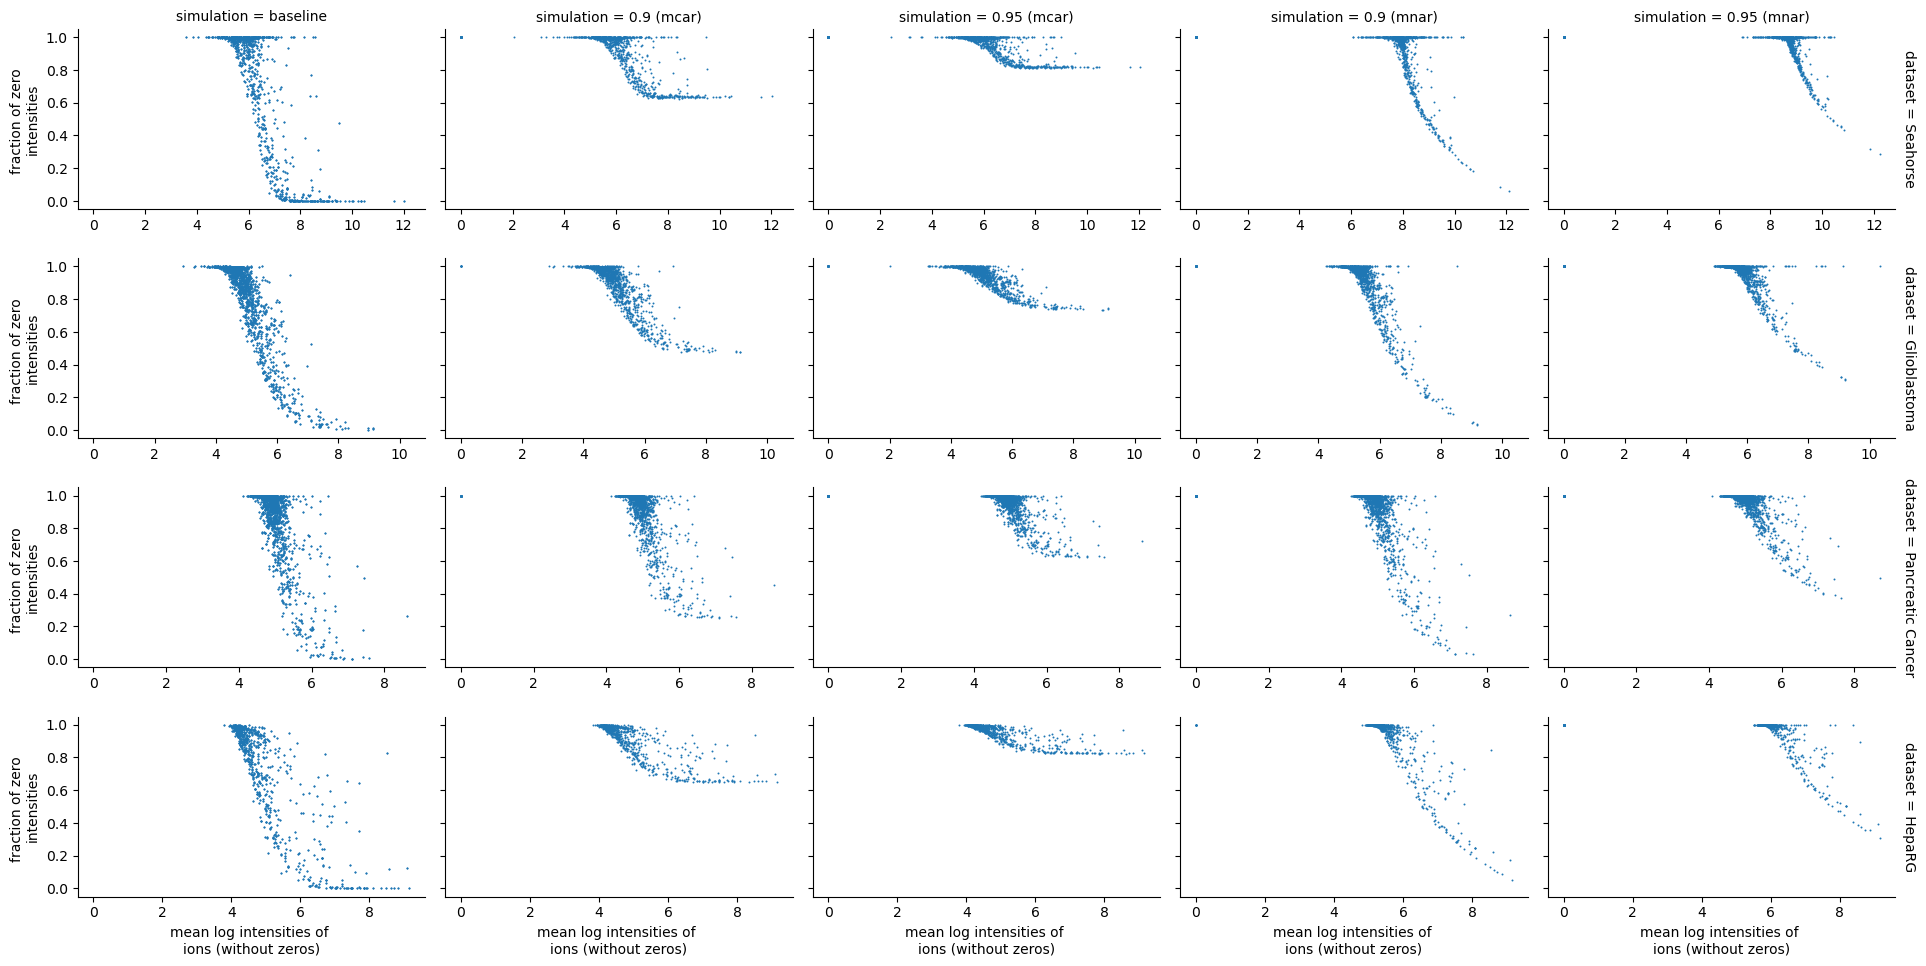

In [57]:
hist_df = hist_backup.copy()
# hist_df = hist_df[hist_df['dropout_ratio'] == 'baseline (mnar)']
#hist_df = hist_df[hist_df['mean_log_intensity_without_zero'] > 0]
hist_df['simulation'] = ['baseline' if 'baseline' in i else i for i in hist_df['dropout_ratio']]

pl = sns.relplot(
    hist_df, 
    x='mean_log_intensity_without_zero',
    y='fraction_of_zeros',
    row='dataset',
    col='simulation',
    height=2.4,
    aspect=1.6, 
    s=2,
    linewidth=0,
    facet_kws=dict(sharex='row', margin_titles=True)
)


pl.set_xlabels(f"mean log intensities of \nions (without zeros)")
pl.set_ylabels(f"fraction of zero \nintensities")

In [63]:
adata.obs['dropout_rate'] = adata.layers['zero_mask'].sum(axis=1) / adata.layers['zero_mask'].shape[1]

<AxesSubplot:xlabel='dropout_rate', ylabel='Count'>

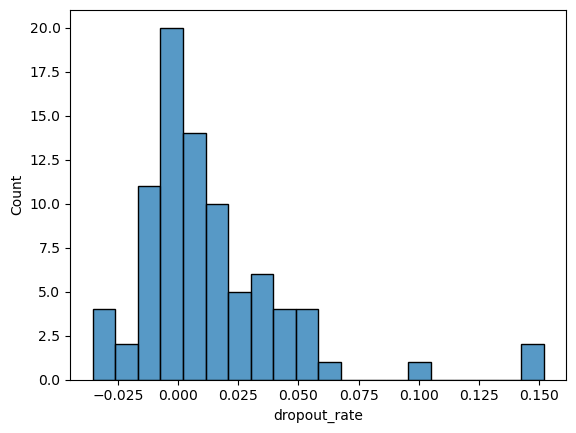

In [79]:
correlations = adata.obs[[
    'dropout_rate', 'cell_area', 'cell_sampled_area', 
    'cell_sampled_proportion', 'cell_sampling_specificity',
    'ablation_mark_area', 'am_intensity_mean-mCherry',
    'am_overlap_count', 'am_sampling_area', 'am_sampling_proportion',
    'Neighbors_AngleBetweenNeighbors_Adjacent',
    'Neighbors_FirstClosestDistance_Adjacent',
    'Neighbors_FirstClosestObjectNumber_Adjacent',
    'Neighbors_NumberOfNeighbors_Adjacent',
    'Neighbors_PercentTouching_Adjacent',
    'Neighbors_SecondClosestDistance_Adjacent',
    'Neighbors_SecondClosestObjectNumber_Adjacent', 'centroid-1',
    'centroid-0', 'axis_major_length', 'axis_minor_length',
    'compactness', 'eccentricity', 'extent', 'euler_number',
    'feret_diameter_max', 'feret_diameter_min', 'form_factor',
    'moments_zernike_0_0', 'moments_zernike_1_1',
    'moments_zernike_2_0', 'moments_zernike_2_2',
    'moments_zernike_3_1', 'moments_zernike_3_3',
    'moments_zernike_4_0', 'moments_zernike_4_2',
    'moments_zernike_4_4', 'moments_zernike_5_1',
    'moments_zernike_5_3', 'moments_zernike_5_5',
    'moments_zernike_6_0', 'moments_zernike_6_2',
    'moments_zernike_6_4', 'moments_zernike_6_6',
    'moments_zernike_7_1', 'moments_zernike_7_3',
    'moments_zernike_7_5', 'moments_zernike_7_7',
    'moments_zernike_8_0', 'moments_zernike_8_2',
    'moments_zernike_8_4', 'moments_zernike_8_6',
    'moments_zernike_8_8', 'moments_zernike_9_1',
    'moments_zernike_9_3', 'moments_zernike_9_5',
    'moments_zernike_9_7', 'moments_zernike_9_9', 'orientation',
    'perimeter', 'radius_max', 'radius_mean', 'radius_median',
    'solidity', 'intensity_sum_edge-OrigBlue',
    'intensity_sum_edge-OrigRed_highDR', 'intensity_sum-OrigBlue',
    'intensity_sum-OrigRed_highDR',
    'intensity_quartile_lower-OrigBlue',
    'intensity_quartile_lower-OrigRed_highDR',
    'intensity_mad-OrigBlue', 'intensity_mad-OrigRed_highDR',
    'intensity_mass_displacement-OrigBlue',
    'intensity_mass_displacement-OrigRed_highDR',
    'intensity_max_edge-OrigBlue', 'intensity_max_edge-OrigRed_highDR',
    'intensity_max-OrigBlue', 'intensity_max-OrigRed_highDR',
    'intensity_mean_edge-OrigBlue',
    'intensity_mean_edge-OrigRed_highDR', 'intensity_mean-OrigBlue',
    'intensity_mean-OrigRed_highDR', 'intensity_median-OrigBlue',
    'intensity_median-OrigRed_highDR', 'intensity_min_edge-OrigBlue'
]].corr()[['dropout_rate']]

correlations.loc['dropout_rate'] = np.nan
sns.histplot(correlations, x='dropout_rate', bins=20)

/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='pearson', ylabel='-log pval'>

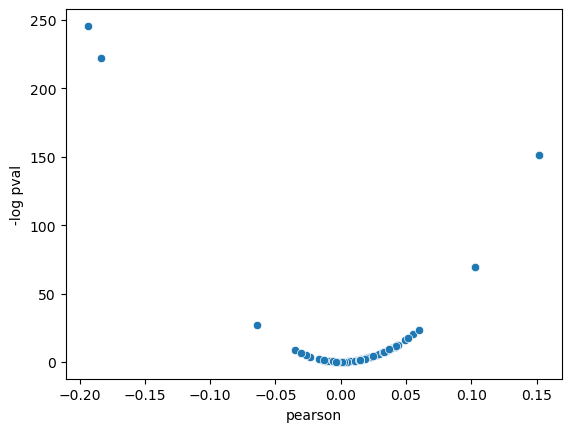

In [88]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

cols = adata.obs.select_dtypes(include='number').columns.tolist()
correlations_list = []
for col in cols:
    df = adata.obs[[col, 'dropout_rate']].replace([np.inf, -np.inf], np.nan).dropna()
    try:
        pearson = pearsonr(adata.obs['dropout_rate'], adata.obs[col])
        correlations_list.append(dict(var=col, pearson=pearson.statistic, pvalue=pearson.pvalue))
    except:
        pass

correlations_df = pd.DataFrame(correlations_list).dropna()
correlations_df['pval_adj'] = multipletests(correlations_df['pvalue'], method='fdr_bh')[1]
correlations_df['-log pval'] = -np.log10(correlations_df['pval_adj'])
sns.scatterplot(data=correlations_df, x='pearson', y='-log pval')

In [91]:
correlations_df[np.abs(correlations_df['pearson']) > 0.1]
sign_vars = correlations_df.loc[np.abs(correlations_df['pearson']) > 0.1, 'var'].tolist()

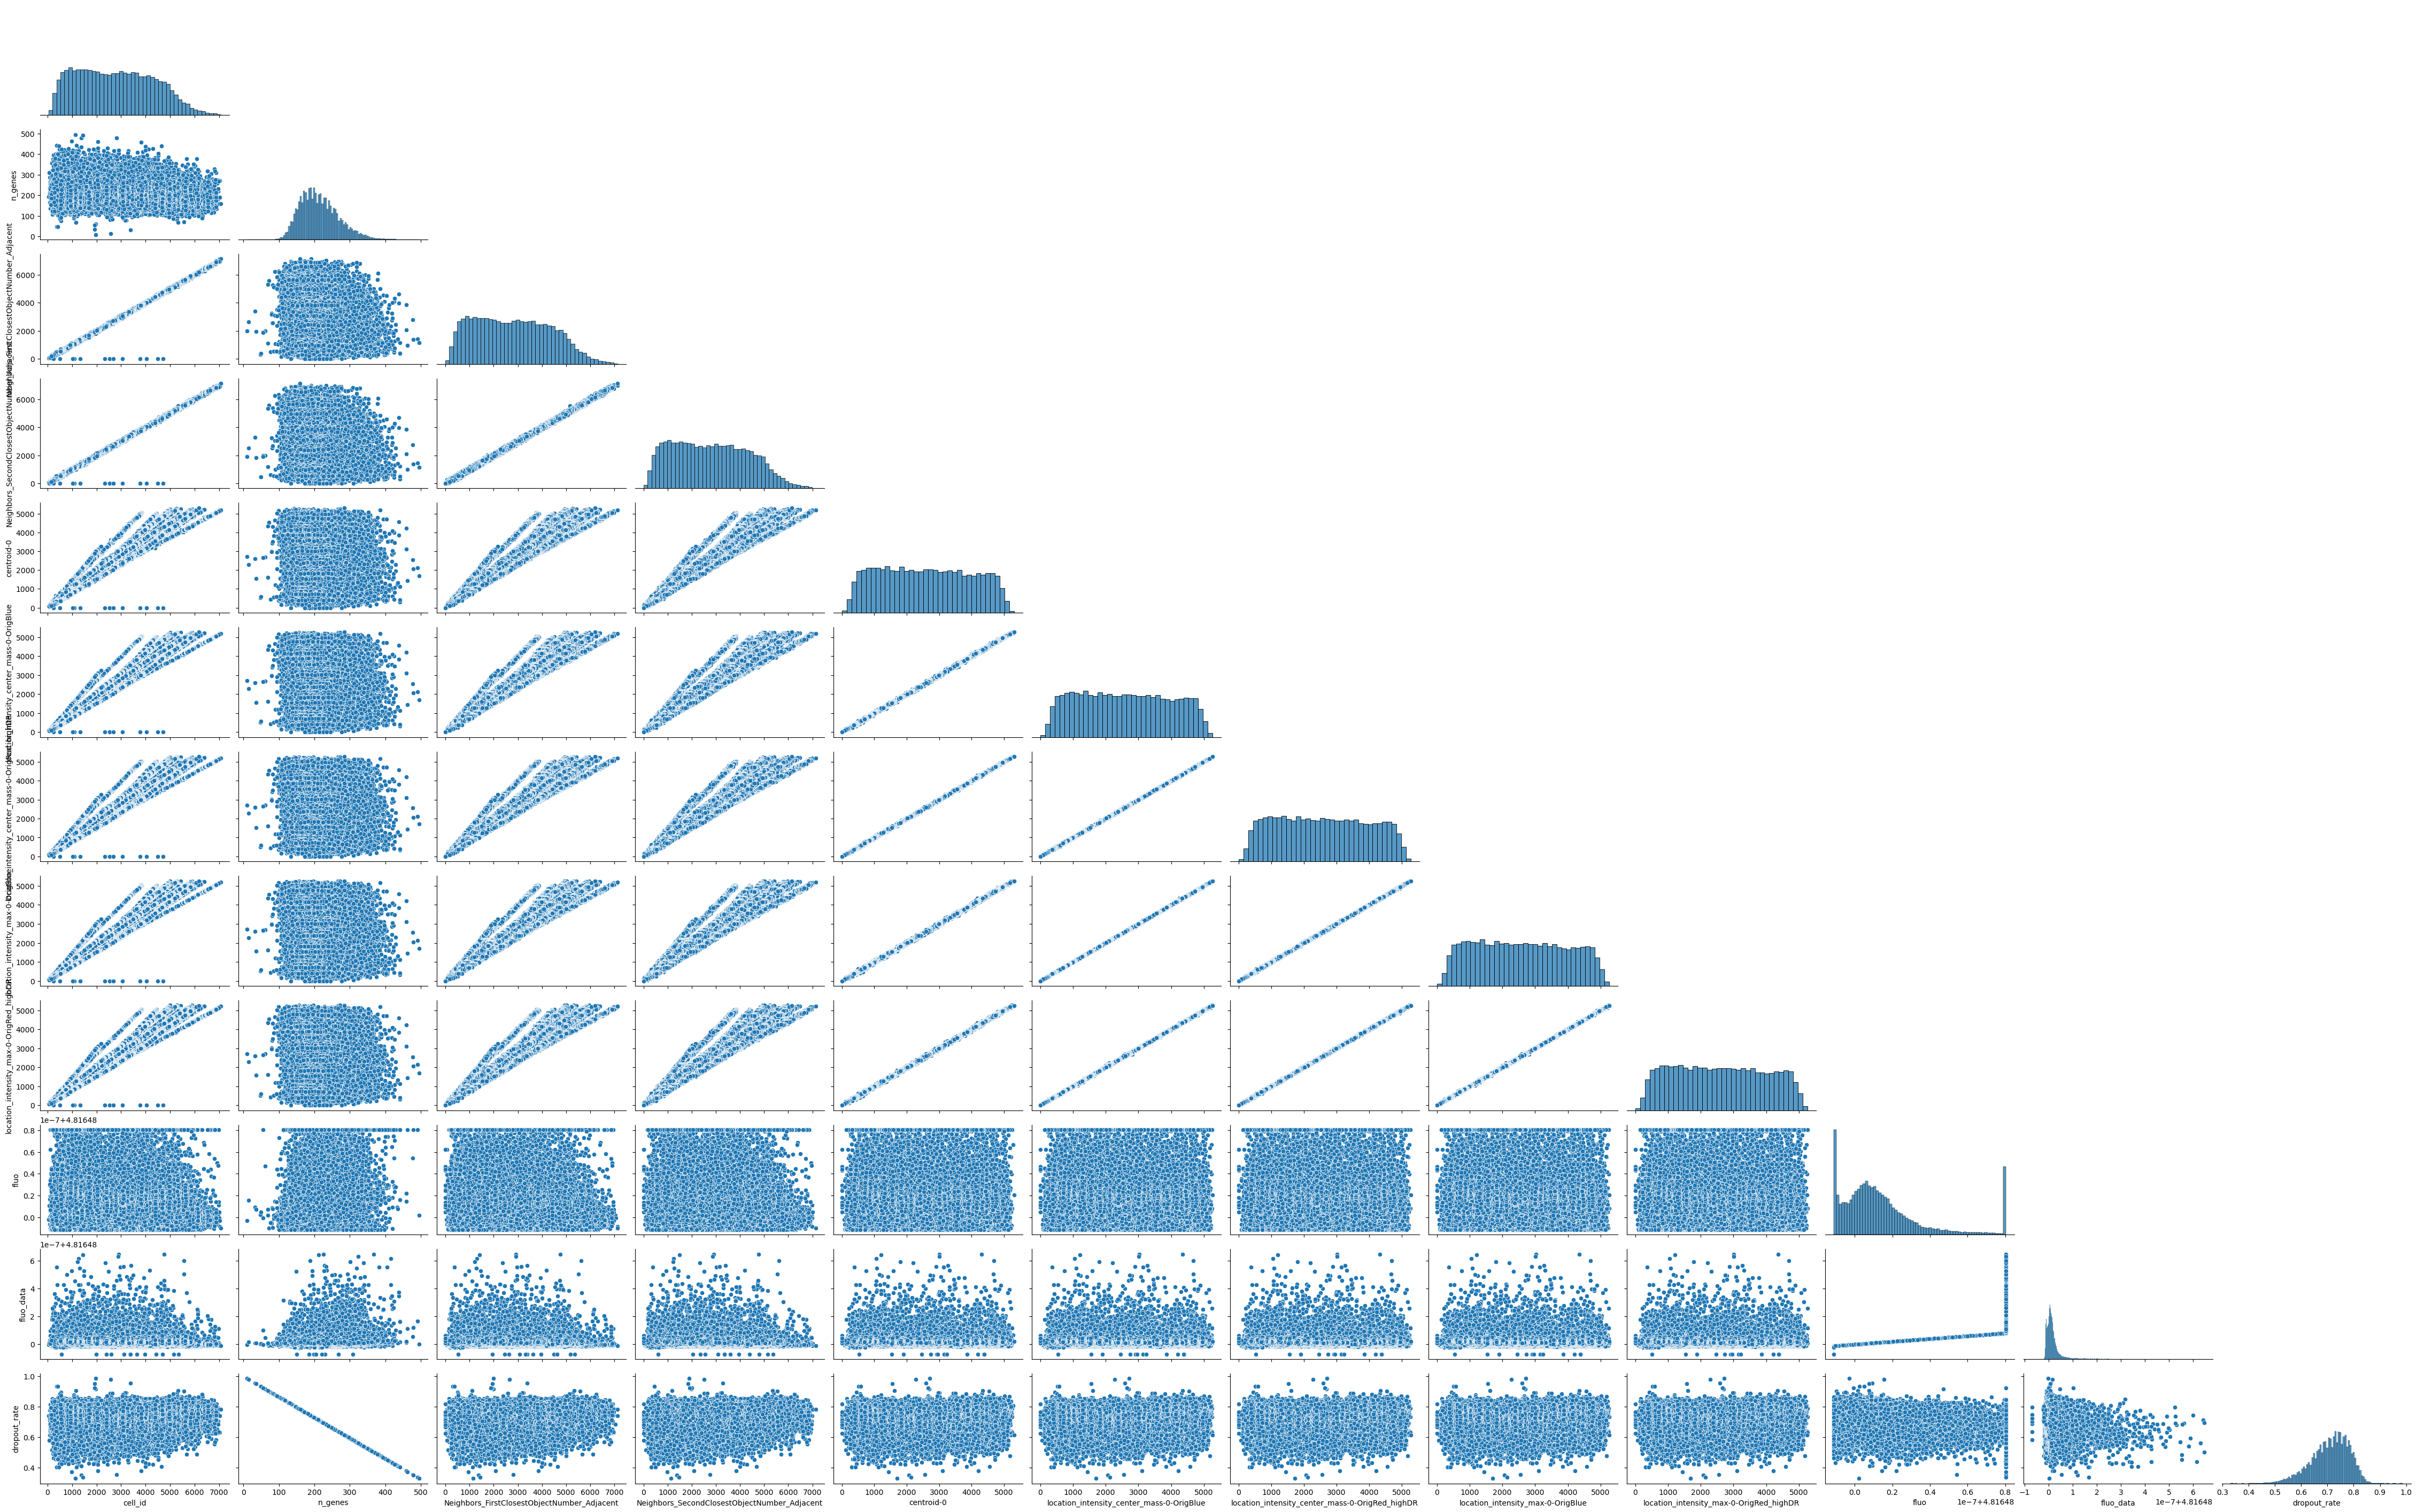

In [92]:
sns.pairplot(adata.obs[sign_vars], height=2.4, aspect=1.6, corner=True)